# Binary Logistic Regression-Chimbuko Provenance Database

## 1- Importing / Installing packages: (Import all the necessary libraries)

In [1]:
import json
import pandas as pd
import numpy as np 
from collections import defaultdict
from typing import Dict, Any
import hashlib

## 2- Import/Prepare the data: Cleaning the data to remove unwanted data, missing values, rows, and columns, duplicate values, data type conversion, etc

In [2]:
# Loading the data
with open('anomalies.dump', 'r') as f:
    data = json.load(f)
df = pd.DataFrame(data)

# List all the features (columns) in the dataset
df.columns

Index(['__id', 'algo_params', 'call_stack', 'counter_events', 'entry',
       'event_id', 'event_window', 'exit', 'fid', 'func', 'gpu_location',
       'gpu_parent', 'hostname', 'io_step', 'io_step_tend', 'io_step_tstart',
       'is_gpu_event', 'outlier_score', 'outlier_severity', 'pid', 'rid',
       'runtime_exclusive', 'runtime_total', 'tid'],
      dtype='object')

In [3]:
# print the shape
print(df.shape)

# runs the first 5 rows
df.head(5)

# Inspect the type of each feature
df.dtypes

(50226, 24)


__id                   int64
algo_params           object
call_stack            object
counter_events        object
entry                  int64
event_id              object
event_window          object
exit                   int64
fid                    int64
func                  object
gpu_location          object
gpu_parent            object
hostname              object
io_step                int64
io_step_tend           int64
io_step_tstart         int64
is_gpu_event            bool
outlier_score        float64
outlier_severity       int64
pid                    int64
rid                    int64
runtime_exclusive      int64
runtime_total          int64
tid                    int64
dtype: object

In [4]:
# Adding a new column in the data where we compute the duration of the io_step
#df['runtime_io']=df['io_step_tend']-df['io_step_tstart']

In [5]:
 # Transform boolean to integer
df['is_gpu_event'] = df['is_gpu_event'].astype(int)   

In [6]:
# Create copy of DataFrame
data_new = df.copy()              

In [7]:
#Find the statiscal values of the outlier_score

med = data_new['outlier_score'].median()
print(med)
data_new.describe()

100.000111389792


__id         entry          exit           fid       io_step  \
count  50226.000000  5.022600e+04  5.022600e+04  50226.000000  50226.000000   
mean    3168.328236  1.648662e+15  1.648662e+15    304.074404   5443.785290   
std     1863.048709  2.207485e+08  2.210411e+08    197.188713   5094.982323   
min        0.000000  1.648662e+15  1.648662e+15      0.000000      0.000000   
25%     1569.000000  1.648662e+15  1.648662e+15    142.000000    240.000000   
50%     3139.000000  1.648662e+15  1.648662e+15    289.000000   5900.000000   
75%     4708.000000  1.648662e+15  1.648662e+15    491.000000  10340.000000   
max     7430.000000  1.648663e+15  1.648663e+15   2081.000000  21420.000000   

       io_step_tend  io_step_tstart  is_gpu_event  outlier_score  \
count  5.022600e+04    5.022600e+04  50226.000000   50226.000000   
mean   1.648662e+15    1.648662e+15      0.160335      58.727123   
std    2.226728e+08    2.247588e+08      0.366920      46.199176   
min    1.648662e+15    1.648662e+15      0.000000       1.000000   
25%    1.648662e+15    1.648662e+15      0.000000       5.693762   
50%    1.648662e+15    1.648662e+15      0.000000     100.000111   
75%    1.648662e+15    1.648662e+15      0.000000     100.000111   
max    1.648663e+15    1.648663e+15      1.000000     100.000111   

       outlier_severity      pid           rid  runtime_exclusive  \
count      5.022600e+04  50226.0  50226.000000       5.022600e+04   
mean       3.142572e+05      0.0    271.916517       3.142572e+05   
std        2.456386e+06      0.0    154.238876       2.456386e+06   
min        0.000000e+00      0.0      0.000000       0.000000e+00   
25%        3.700000e+01      0.0    129.000000       3.700000e+01   
50%        6.580000e+02      0.0    298.000000       6.580000e+02   
75%        2.922100e+04      0.0    407.000000       2.922100e+04   
max        6.339329e+07      0.0    499.000000       6.339329e+07   

       runtime_total           tid  
count   5.022600e+04  50226.000000  
mean    1.659127e+06      2.193266  
std     1.827347e+07      4.761257  
min     0.000000e+00      0.000000  
25%     8.300000e+01      0.000000  
50%     2.226000e+03      0.000000  
75%     7.908500e+04      0.000000  
max     1.047225e+09     52.000000

In [8]:
# Define the binary output value from the feature (outlier_score)
# create a list of our conditions

conditions = [
    (data_new['outlier_score'] <5.21),
    (data_new['outlier_score'] >= 5.21) & (data_new['outlier_score'] <= 26),
    (data_new['outlier_score'] > 26)
    ]

#conditions = [
    #(data_new['outlier_score'] <=26),
    #(data_new['outlier_score'] > 26)
    #]

# create a list of the values we want to assign for each condition
values = [0, 1, np.nan]
#values = [0, 1]
# create a new column and use np.select to assign values to it using our lists as arguments
data_new['score'] = np.select(conditions, values)

# display updated DataFrame
data_new.head()

__id                                        algo_params  \
0     0  {'histogram': {'Histogram Bin Counts': [3, 5, ...   
1     1  {'histogram': {'Histogram Bin Counts': [4, 7, ...   
2     2  {'histogram': {'Histogram Bin Counts': [20, 24...   
3     3  {'histogram': {'Histogram Bin Counts': [9, 8, ...   
4     4  {'histogram': {'Histogram Bin Counts': [2, 3, ...   

                                          call_stack  \
0  [{'entry': 1648661826572801, 'event_id': '392:...   
1  [{'entry': 1648661820195145, 'event_id': '392:...   
2  [{'entry': 1648661820195024, 'event_id': '392:...   
3  [{'entry': 1648661820200575, 'event_id': '392:...   
4  [{'entry': 1648661820396855, 'event_id': '392:...   

                                      counter_events             entry  \
0                                                 []  1648661826572801   
1                                                 []  1648661820195145   
2                                                 []  1648661820195024   
3                                                 []  1648661820200575   
4  [{'counter_idx': 0, 'counter_name': 'Message s...  1648661820396855   

   event_id                                       event_window  \
0  392:0:46  {'comm_window': [], 'exec_window': [{'entry': ...   
1   392:0:5  {'comm_window': [], 'exec_window': [{'entry': ...   
2   392:0:1  {'comm_window': [], 'exec_window': [{'entry': ...   
3   392:0:7  {'comm_window': [], 'exec_window': [{'entry': ...   
4  392:0:43  {'comm_window': [], 'exec_window': [{'entry': ...   

               exit  fid                      func  ...    io_step_tstart  \
0  1648661826572842   13            pthread_create  ...  1648661810277490   
1  1648661820195152  334           MPI_Comm_size()  ...  1648661810277490   
2  1648661820195033  223           MPI_Comm_rank()  ...  1648661810277490   
3  1648661820200593  445  MPI_Get_processor_name()  ...  1648661810277490   
4  1648661820396921  594               MPI_Bcast()  ...  1648661810277490   

  is_gpu_event outlier_score  outlier_severity  pid  rid  runtime_exclusive  \
0            0      2.000000                41    0  392                 41   
1            0      4.169925                 7    0  392                  7   
2            0      3.584963                 9    0  392                  9   
3            0    100.000111                18    0  392                 18   
4            0      3.584963                66    0  392                 66   

   runtime_total  tid  score  
0             41    0    0.0  
1              7    0    0.0  
2              9    0    0.0  
3             18    0    NaN  
4             66    0    0.0  

[5 rows x 25 columns]

In [9]:
# Get number of rows in DataFrame 
n = len(data_new.index)
n

50226

In [10]:
#We define the function to hash a dictionary

def dict_hash(dictionary: Dict[str, Any]) -> str:
    """MD5 hash of a dictionary."""
    dhash = hashlib.md5()
    # We need to sort arguments so {'a': 1, 'b': 2} is
    # the same as {'b': 2, 'a': 1}
    encoded = json.dumps(dictionary, sort_keys=True).encode()
    dhash.update(encoded)
    return dhash.hexdigest()

In [11]:
# Perform the hash of the call_stack

func_id=[]
func_hash=[]
call_stack_func=[]
func=[]
rid=[]
for i in range(n):
    res = defaultdict(list)
    for sub in (data_new['call_stack'][i]):
        for key in sub:
            res[key].append(sub[key])
    call_stack_func.append(res['func'])
    func_id.append(data_new['__id'][i])
    func_hash.append(dict_hash(res['func']))
    func.append(data_new['func'][i])
    rid.append(data_new['rid'][i])

In [12]:
# Creating a Dataframe

func_df = zip(func_id, rid, func_hash, call_stack_func, func)
func_df = pd.DataFrame(func_df, columns = ['__id','rid','hash_func','call_stack_func','func'])
func_df.head()

__id  rid                         hash_func  \
0     0  392  eed8c4ea90b205288aae6e82c49c7392   
1     1  392  731c389ef63cdc69848c29f9b0f45231   
2     2  392  7c747741648f2c536cb8ecde94f3b768   
3     3  392  e802aac4e376612efae9bfe6e12c6ec5   
4     4  392  717dfbe571f28fdd5a07f67efdeaaf35   

                                     call_stack_func                      func  
0  [pthread_create, OpenMP_Parallel_Region _ZN6Ko...            pthread_create  
1            [MPI_Comm_size(), OpenMP_Implicit_Task]           MPI_Comm_size()  
2            [MPI_Comm_rank(), OpenMP_Implicit_Task]           MPI_Comm_rank()  
3   [MPI_Get_processor_name(), OpenMP_Implicit_Task]  MPI_Get_processor_name()  
4                [MPI_Bcast(), OpenMP_Implicit_Task]               MPI_Bcast()

In [13]:
# Create a new column in the DataFrame for the call_stack hash
data_new['hash_func']=func_df['hash_func']
data_new.head()

__id                                        algo_params  \
0     0  {'histogram': {'Histogram Bin Counts': [3, 5, ...   
1     1  {'histogram': {'Histogram Bin Counts': [4, 7, ...   
2     2  {'histogram': {'Histogram Bin Counts': [20, 24...   
3     3  {'histogram': {'Histogram Bin Counts': [9, 8, ...   
4     4  {'histogram': {'Histogram Bin Counts': [2, 3, ...   

                                          call_stack  \
0  [{'entry': 1648661826572801, 'event_id': '392:...   
1  [{'entry': 1648661820195145, 'event_id': '392:...   
2  [{'entry': 1648661820195024, 'event_id': '392:...   
3  [{'entry': 1648661820200575, 'event_id': '392:...   
4  [{'entry': 1648661820396855, 'event_id': '392:...   

                                      counter_events             entry  \
0                                                 []  1648661826572801   
1                                                 []  1648661820195145   
2                                                 []  1648661820195024   
3                                                 []  1648661820200575   
4  [{'counter_idx': 0, 'counter_name': 'Message s...  1648661820396855   

   event_id                                       event_window  \
0  392:0:46  {'comm_window': [], 'exec_window': [{'entry': ...   
1   392:0:5  {'comm_window': [], 'exec_window': [{'entry': ...   
2   392:0:1  {'comm_window': [], 'exec_window': [{'entry': ...   
3   392:0:7  {'comm_window': [], 'exec_window': [{'entry': ...   
4  392:0:43  {'comm_window': [], 'exec_window': [{'entry': ...   

               exit  fid                      func  ... is_gpu_event  \
0  1648661826572842   13            pthread_create  ...            0   
1  1648661820195152  334           MPI_Comm_size()  ...            0   
2  1648661820195033  223           MPI_Comm_rank()  ...            0   
3  1648661820200593  445  MPI_Get_processor_name()  ...            0   
4  1648661820396921  594               MPI_Bcast()  ...            0   

  outlier_score outlier_severity  pid  rid  runtime_exclusive  runtime_total  \
0      2.000000               41    0  392                 41             41   
1      4.169925                7    0  392                  7              7   
2      3.584963                9    0  392                  9              9   
3    100.000111               18    0  392                 18             18   
4      3.584963               66    0  392                 66             66   

   tid  score                         hash_func  
0    0    0.0  eed8c4ea90b205288aae6e82c49c7392  
1    0    0.0  731c389ef63cdc69848c29f9b0f45231  
2    0    0.0  7c747741648f2c536cb8ecde94f3b768  
3    0    NaN  e802aac4e376612efae9bfe6e12c6ec5  
4    0    0.0  717dfbe571f28fdd5a07f67efdeaaf35  

[5 rows x 26 columns]

In [14]:
# Deleting the outlier

data_new = data_new[data_new['outlier_severity'] <= 72995]

data_new.shape

(41841, 26)

In [15]:
# Remove unecessary features from the Dataset

raw_data = data_new.drop(['__id', 'algo_params', 'call_stack', 'counter_events',
       'event_id', 'event_window', 'exit', 'fid', 'func', 'gpu_location',
       'gpu_parent', 'hostname', 'io_step', 'io_step_tend','io_step_tstart','outlier_severity',
        'outlier_score', 'pid','runtime_exclusive'], axis=1)
raw_data.head()

entry  is_gpu_event  rid  runtime_total  tid  score  \
0  1648661826572801             0  392             41    0    0.0   
1  1648661820195145             0  392              7    0    0.0   
2  1648661820195024             0  392              9    0    0.0   
3  1648661820200575             0  392             18    0    NaN   
4  1648661820396855             0  392             66    0    0.0   

                          hash_func  
0  eed8c4ea90b205288aae6e82c49c7392  
1  731c389ef63cdc69848c29f9b0f45231  
2  7c747741648f2c536cb8ecde94f3b768  
3  e802aac4e376612efae9bfe6e12c6ec5  
4  717dfbe571f28fdd5a07f67efdeaaf35

In [16]:
# Transform the features to categorical

raw_data['entry'] = pd.Categorical(raw_data.entry)
#raw_data['io_step_tstart'] = pd.Categorical(raw_data.io_step_tstart)
raw_data['is_gpu_event'] = pd.Categorical(raw_data.is_gpu_event)
raw_data['hash_func'] = pd.Categorical(raw_data.hash_func)

In [17]:
# print the shape of the new data
raw_data.shape

(41841, 7)

In [18]:
# Checking for null values
raw_data.isnull().sum()

entry                0
is_gpu_event         0
rid                  0
runtime_total        0
tid                  0
score            23601
hash_func            0
dtype: int64

In [19]:
# Visualize the NULL observations
raw_data[raw_data['score'].isnull()]

entry is_gpu_event  rid  runtime_total  tid  score  \
3      1648661820200575            0  392             18    0    NaN   
5      1648661820385771            0  392           1831    0    NaN   
8      1648661820390697            0    0             10    0    NaN   
11     1648661820387537            0    0             78    0    NaN   
12     1648661827319466            0  320             40    0    NaN   
...                 ...          ...  ...            ...  ...    ...   
50217  1648662883865721            0  447            122    0    NaN   
50218  1648662834115732            0  191          49862    0    NaN   
50221  1648662884050059            1  407             16   12    NaN   
50222  1648662884050430            1  407              4   12    NaN   
50224  1648662845625000            0  215       16740378    0    NaN   

                              hash_func  
3      e802aac4e376612efae9bfe6e12c6ec5  
5      f7d0c2c66887a79b0e53dc2496c2b8ef  
8      7c747741648f2c536cb8ecde94f3b768  
11     f7d0c2c66887a79b0e53dc2496c2b8ef  
12     eed8c4ea90b205288aae6e82c49c7392  
...                                 ...  
50217  9e687013723946f71d07b6f3f935e48f  
50218  722afb98d5ec88ad331d852dbb9b3aec  
50221  d19518e120343702fadcc956fa6a26c2  
50222  e183dc61b200aa069089667abfbc5625  
50224  f2dc0a9a5a27552ec89a4d8f87490a04  

[23601 rows x 7 columns]

In [20]:
# Deleting the NULL values
raw_data = raw_data.dropna(subset = ['score'])

# Printing the shape
print(raw_data.shape)

# Visualize the NULL observations
raw_data.isnull().sum()

(18240, 7)


entry            0
is_gpu_event     0
rid              0
runtime_total    0
tid              0
score            0
hash_func        0
dtype: int64

In [21]:
# Investigate all the elements whithin each Feature 

for column in raw_data:
    unique_values = np.unique(raw_data[column])
    nr_values = len(unique_values)
    if nr_values <= 10:
        print("The number of values for feature {} is: {} -- {}".format(column, nr_values, unique_values))
    else:
        print("The number of values for feature {} is: {}".format(column, nr_values))

The number of values for feature entry is: 17532
The number of values for feature is_gpu_event is: 2 -- [0 1]
The number of values for feature rid is: 500
The number of values for feature runtime_total is: 8366
The number of values for feature tid is: 15
The number of values for feature score is: 2 -- [0. 1.]
The number of values for feature hash_func is: 1032


In [22]:
# Inspect the type of each feature
raw_data.dtypes

entry            category
is_gpu_event     category
rid                 int64
runtime_total       int64
tid                 int64
score             float64
hash_func        category
dtype: object

In [23]:
# Scaling our columns

#scale_vars = ['entry','exit','io_step_tend','io_step_tstart']
#scaler = MinMaxScaler()
#new_raw_data[scale_vars] = scaler.fit_transform(new_raw_data[scale_vars])
#new_raw_data.head()

### Visualiztion of the data

In [24]:
# Visualize the data using seaborn Pairplots

#g = sns.pairplot(raw_data)

# Notes: Do not run this on a big dataset. Filter the columns first

In [25]:
# Visualize the data using seaborn Pairplots with the output feature

#g = sns.pairplot(raw_data, hue = 'score')

In [26]:
# Investigating the distr of y

#sns.countplot(x = 'score', data = raw_data, palette = 'Set3')

In [27]:
raw_data.columns

Index(['entry', 'is_gpu_event', 'rid', 'runtime_total', 'tid', 'score',
       'hash_func'],
      dtype='object')

In [28]:
# Looping through all the categorical features by our y variable - see if there is relationship

#features = ['entry', 'is_gpu_event', 'hash_func']

#for f in features:
    #sns.countplot(x = f, data = raw_data, palette = 'Set3', hue = 'score')
    #plt.show()

In [29]:
# Making categorical variables into numeric representation

new_raw_data = pd.get_dummies(raw_data, 'hash_func')#columns = features)

# Notes:
# We can also do this with Label Encoding and OneHotEncoder from the preprocessing library

print(raw_data.shape)
# print the shape
print(new_raw_data.shape)

(18240, 7)
(18240, 40159)


In [30]:
new_raw_data.columns

Index(['rid', 'runtime_total', 'tid', 'score', 'hash_func_1648661812458829',
       'hash_func_1648661812548041', 'hash_func_1648661812567549',
       'hash_func_1648661812614382', 'hash_func_1648661812614504',
       'hash_func_1648661812646959',
       ...
       'hash_func_feb95a58c54ff12118e835b24d637a0f',
       'hash_func_feba9f14e7c5062f94ad9d1160d1c082',
       'hash_func_fee6e6b1806b0cba842842c9bfc48037',
       'hash_func_ff32fe872a46db918b58fbe5454299a5',
       'hash_func_ff3326d89e1c807230ff411af28ed636',
       'hash_func_ff4ed521c97d945e34211e70e4060e93',
       'hash_func_ff8219c24c4467bed5f9dd1201feb40e',
       'hash_func_ff8b4a0af9e00589a5eafaedf39ceaba',
       'hash_func_ffe58d822d63961ef7c46e6ac8d083d8',
       'hash_func_fff8f29e2bfb2adeac49dc3175668aeb'],
      dtype='object', length=40159)

## 3- Import the selected algorithm

In [31]:
# Packages / libraries
import os #provides functions for interacting with the operating system
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix, accuracy_score, classification_report, log_loss
from math import sqrt

%matplotlib inline

# To install sklearn type "pip install numpy scipy scikit-learn" to the anaconda terminal

# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# Increases the size of sns plots
sns.set(rc={'figure.figsize':(12,10)})

# import sys
# !conda list Check the packages installed

### Feature Selection
Steps of Running Feature Importance
Split the data into X & y
Run a Tree-based estimators (i.e. decision trees & random forests)
Run Feature Importance

In [32]:
# Split the data into X & y

X = new_raw_data.drop('score', axis = 1).values
y = new_raw_data['score']

y = y.astype(int)

print(X.shape)
print(y.shape)

(18240, 40158)
(18240,)


In [33]:
# Run a Tree-based estimators (i.e. decision trees & random forests)

dt = DecisionTreeClassifier(random_state=15, criterion = 'entropy', max_depth = 10)
dt.fit(X,y)

# If you want to learn how Decesion Trees work, read here: https://www.datacamp.com/community/tutorials/decision-tree-classification-python
# Official Doc: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=15)

#### Notes:
- The importance of a feature is calculated as the (normalized) total reduction of entropy (other criterions too) brought by that feature or the higher information gain
- To understand the maths, read this: https://towardsdatascience.com/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3

In [34]:
# Running Feature Importance

fi_col = []
fi = []

for i,column in enumerate(new_raw_data.drop('score', axis = 1)):
    print('The feature importance for {} is : {}'.format(column, dt.feature_importances_[i]))
    
    fi_col.append(column)
    fi.append(dt.feature_importances_[i])

The feature importance for rid is : 0.06115217271486494
The feature importance for runtime_total is : 0.2610655199188772
The feature importance for tid is : 0.12924496591591678
The feature importance for hash_func_1648661812458829 is : 0.0
The feature importance for hash_func_1648661812548041 is : 0.0
The feature importance for hash_func_1648661812567549 is : 0.0
The feature importance for hash_func_1648661812614382 is : 0.0
The feature importance for hash_func_1648661812614504 is : 0.0
The feature importance for hash_func_1648661812646959 is : 0.0
The feature importance for hash_func_1648661812654460 is : 0.0
The feature importance for hash_func_1648661812696849 is : 0.0
The feature importance for hash_func_1648661812696988 is : 0.0
The feature importance for hash_func_1648661812698598 is : 0.0
The feature importance for hash_func_1648661812698753 is : 0.0
The feature importance for hash_func_1648661812698896 is : 0.0
The feature importance for hash_func_1648661812704217 is : 0.0
The 

The feature importance for hash_func_1648661820164004 is : 0.0
The feature importance for hash_func_1648661820173606 is : 0.0
The feature importance for hash_func_1648661820173746 is : 0.0
The feature importance for hash_func_1648661820184149 is : 0.0
The feature importance for hash_func_1648661820184409 is : 0.0
The feature importance for hash_func_1648661820184509 is : 0.0
The feature importance for hash_func_1648661820193131 is : 0.0
The feature importance for hash_func_1648661820193155 is : 0.0
The feature importance for hash_func_1648661820193263 is : 0.0
The feature importance for hash_func_1648661820193506 is : 0.0
The feature importance for hash_func_1648661820193643 is : 0.0
The feature importance for hash_func_1648661820193649 is : 0.0
The feature importance for hash_func_1648661820193755 is : 0.0
The feature importance for hash_func_1648661820193918 is : 0.0
The feature importance for hash_func_1648661820194959 is : 0.0
The feature importance for hash_func_1648661820195024 i

The feature importance for hash_func_1648661826644703 is : 0.0
The feature importance for hash_func_1648661826645079 is : 0.0
The feature importance for hash_func_1648661826645337 is : 0.0
The feature importance for hash_func_1648661826645585 is : 0.0
The feature importance for hash_func_1648661826645812 is : 0.0
The feature importance for hash_func_1648661826646211 is : 0.0
The feature importance for hash_func_1648661826654933 is : 0.0
The feature importance for hash_func_1648661826655288 is : 0.0
The feature importance for hash_func_1648661826655615 is : 0.0
The feature importance for hash_func_1648661826655976 is : 0.0
The feature importance for hash_func_1648661826656015 is : 0.0
The feature importance for hash_func_1648661826656201 is : 0.0
The feature importance for hash_func_1648661826657610 is : 0.0
The feature importance for hash_func_1648661826661132 is : 0.0
The feature importance for hash_func_1648661826665318 is : 0.0
The feature importance for hash_func_1648661826666405 i

The feature importance for hash_func_1648661827568837 is : 0.0
The feature importance for hash_func_1648661827569097 is : 0.0
The feature importance for hash_func_1648661827569345 is : 0.0
The feature importance for hash_func_1648661827569712 is : 0.0
The feature importance for hash_func_1648661827572870 is : 0.0
The feature importance for hash_func_1648661827573232 is : 0.0
The feature importance for hash_func_1648661827573516 is : 0.0
The feature importance for hash_func_1648661827573773 is : 0.0
The feature importance for hash_func_1648661827574005 is : 0.0
The feature importance for hash_func_1648661827574403 is : 0.0
The feature importance for hash_func_1648661827575366 is : 0.0
The feature importance for hash_func_1648661827575618 is : 0.0
The feature importance for hash_func_1648661827575718 is : 0.0
The feature importance for hash_func_1648661827575899 is : 0.0
The feature importance for hash_func_1648661827576126 is : 0.0
The feature importance for hash_func_1648661827576352 i

The feature importance for hash_func_1648661831447479 is : 0.0
The feature importance for hash_func_1648661831447602 is : 0.0
The feature importance for hash_func_1648661831447691 is : 0.0
The feature importance for hash_func_1648661831447714 is : 0.0
The feature importance for hash_func_1648661831447842 is : 0.0
The feature importance for hash_func_1648661831447936 is : 0.0
The feature importance for hash_func_1648661831448070 is : 0.0
The feature importance for hash_func_1648661831481894 is : 0.0
The feature importance for hash_func_1648661831496375 is : 0.0
The feature importance for hash_func_1648661831521733 is : 0.0
The feature importance for hash_func_1648661831727347 is : 0.0
The feature importance for hash_func_1648661831727613 is : 0.0
The feature importance for hash_func_1648661831728189 is : 0.0
The feature importance for hash_func_1648661831728221 is : 0.0
The feature importance for hash_func_1648661831728870 is : 0.0
The feature importance for hash_func_1648661831730596 i

The feature importance for hash_func_1648661834263844 is : 0.0
The feature importance for hash_func_1648661834264108 is : 0.0
The feature importance for hash_func_1648661834264120 is : 0.0
The feature importance for hash_func_1648661834264241 is : 0.0
The feature importance for hash_func_1648661834264267 is : 0.0
The feature importance for hash_func_1648661834264537 is : 0.0
The feature importance for hash_func_1648661834264546 is : 0.0
The feature importance for hash_func_1648661834264666 is : 0.0
The feature importance for hash_func_1648661834264694 is : 0.0
The feature importance for hash_func_1648661834264780 is : 0.0
The feature importance for hash_func_1648661834264786 is : 0.0
The feature importance for hash_func_1648661834264905 is : 0.0
The feature importance for hash_func_1648661834264938 is : 0.0
The feature importance for hash_func_1648661834265008 is : 0.0
The feature importance for hash_func_1648661834265012 is : 0.0
The feature importance for hash_func_1648661834265135 i

The feature importance for hash_func_1648661836231936 is : 0.0
The feature importance for hash_func_1648661836231974 is : 0.0
The feature importance for hash_func_1648661836232074 is : 0.0
The feature importance for hash_func_1648661836234791 is : 0.0
The feature importance for hash_func_1648661836239057 is : 0.0
The feature importance for hash_func_1648661836239723 is : 0.0
The feature importance for hash_func_1648661836240582 is : 0.0
The feature importance for hash_func_1648661836242317 is : 0.0
The feature importance for hash_func_1648661836357211 is : 0.0
The feature importance for hash_func_1648661836357724 is : 0.0
The feature importance for hash_func_1648661836358256 is : 0.0
The feature importance for hash_func_1648661836358387 is : 0.0
The feature importance for hash_func_1648661836359483 is : 0.0
The feature importance for hash_func_1648661836359666 is : 0.0
The feature importance for hash_func_1648661836360143 is : 0.0
The feature importance for hash_func_1648661836362878 i

The feature importance for hash_func_1648661836768744 is : 0.0
The feature importance for hash_func_1648661836768745 is : 0.0
The feature importance for hash_func_1648661836768746 is : 0.0
The feature importance for hash_func_1648661836768749 is : 0.0
The feature importance for hash_func_1648661836768759 is : 0.0
The feature importance for hash_func_1648661836768761 is : 0.0
The feature importance for hash_func_1648661836768762 is : 0.0
The feature importance for hash_func_1648661836768763 is : 0.0
The feature importance for hash_func_1648661836768767 is : 0.0
The feature importance for hash_func_1648661836768769 is : 0.0
The feature importance for hash_func_1648661836768771 is : 0.0
The feature importance for hash_func_1648661836768773 is : 0.0
The feature importance for hash_func_1648661836768775 is : 0.0
The feature importance for hash_func_1648661836768780 is : 0.0
The feature importance for hash_func_1648661836768781 is : 0.0
The feature importance for hash_func_1648661836768782 i

The feature importance for hash_func_1648661836796543 is : 0.0
The feature importance for hash_func_1648661836797684 is : 0.0
The feature importance for hash_func_1648661836797686 is : 0.0
The feature importance for hash_func_1648661836797690 is : 0.0
The feature importance for hash_func_1648661836797693 is : 0.0
The feature importance for hash_func_1648661836797694 is : 0.0
The feature importance for hash_func_1648661836797695 is : 0.0
The feature importance for hash_func_1648661836797696 is : 0.0
The feature importance for hash_func_1648661836797697 is : 0.0
The feature importance for hash_func_1648661836797700 is : 0.0
The feature importance for hash_func_1648661836797701 is : 0.0
The feature importance for hash_func_1648661836797749 is : 0.0
The feature importance for hash_func_1648661836797751 is : 0.0
The feature importance for hash_func_1648661836797755 is : 0.0
The feature importance for hash_func_1648661836797756 is : 0.0
The feature importance for hash_func_1648661836797760 i

The feature importance for hash_func_1648661837065930 is : 0.0
The feature importance for hash_func_1648661837066536 is : 0.0
The feature importance for hash_func_1648661837066624 is : 0.0
The feature importance for hash_func_1648661837066664 is : 0.0
The feature importance for hash_func_1648661837066819 is : 0.0
The feature importance for hash_func_1648661837066838 is : 0.0
The feature importance for hash_func_1648661837066855 is : 0.0
The feature importance for hash_func_1648661837066878 is : 0.0
The feature importance for hash_func_1648661837066931 is : 0.0
The feature importance for hash_func_1648661837067222 is : 0.0
The feature importance for hash_func_1648661837067251 is : 0.0
The feature importance for hash_func_1648661837067284 is : 0.0
The feature importance for hash_func_1648661837067324 is : 0.0
The feature importance for hash_func_1648661837067341 is : 0.0
The feature importance for hash_func_1648661837067394 is : 0.0
The feature importance for hash_func_1648661837067664 i

The feature importance for hash_func_1648661837209815 is : 0.0
The feature importance for hash_func_1648661837209821 is : 0.0
The feature importance for hash_func_1648661837209823 is : 0.0
The feature importance for hash_func_1648661837209824 is : 0.0
The feature importance for hash_func_1648661837209825 is : 0.0
The feature importance for hash_func_1648661837209826 is : 0.0
The feature importance for hash_func_1648661837209827 is : 0.0
The feature importance for hash_func_1648661837209828 is : 0.0
The feature importance for hash_func_1648661837209829 is : 0.0
The feature importance for hash_func_1648661837209834 is : 0.0
The feature importance for hash_func_1648661837209836 is : 0.0
The feature importance for hash_func_1648661837209838 is : 0.0
The feature importance for hash_func_1648661837209839 is : 0.0
The feature importance for hash_func_1648661837209840 is : 0.0
The feature importance for hash_func_1648661837209841 is : 0.0
The feature importance for hash_func_1648661837209842 i

The feature importance for hash_func_1648661839869767 is : 0.0
The feature importance for hash_func_1648661839869833 is : 0.0
The feature importance for hash_func_1648661839869883 is : 0.0
The feature importance for hash_func_1648661839869902 is : 0.0
The feature importance for hash_func_1648661839869932 is : 0.0
The feature importance for hash_func_1648661839869962 is : 0.0
The feature importance for hash_func_1648661839869985 is : 0.0
The feature importance for hash_func_1648661839870028 is : 0.0
The feature importance for hash_func_1648661839870050 is : 0.0
The feature importance for hash_func_1648661839870074 is : 0.0
The feature importance for hash_func_1648661839870336 is : 0.0
The feature importance for hash_func_1648661839870424 is : 0.0
The feature importance for hash_func_1648661839870540 is : 0.0
The feature importance for hash_func_1648661839870601 is : 0.0
The feature importance for hash_func_1648661839870612 is : 0.0
The feature importance for hash_func_1648661839870640 i

The feature importance for hash_func_1648661840863519 is : 0.0
The feature importance for hash_func_1648661840863523 is : 0.0
The feature importance for hash_func_1648661840863531 is : 0.0
The feature importance for hash_func_1648661840863536 is : 0.0
The feature importance for hash_func_1648661840863644 is : 0.0
The feature importance for hash_func_1648661840863666 is : 0.0
The feature importance for hash_func_1648661840863727 is : 0.0
The feature importance for hash_func_1648661840863754 is : 0.0
The feature importance for hash_func_1648661840863771 is : 0.0
The feature importance for hash_func_1648661840863847 is : 0.0
The feature importance for hash_func_1648661840863900 is : 0.0
The feature importance for hash_func_1648661840863968 is : 0.0
The feature importance for hash_func_1648661840863971 is : 0.0
The feature importance for hash_func_1648661840863978 is : 0.0
The feature importance for hash_func_1648661840863989 is : 0.0
The feature importance for hash_func_1648661840864010 i

The feature importance for hash_func_1648661842166192 is : 0.0
The feature importance for hash_func_1648661842166222 is : 0.0
The feature importance for hash_func_1648661842166279 is : 0.0
The feature importance for hash_func_1648661842166343 is : 0.0
The feature importance for hash_func_1648661842166424 is : 0.0
The feature importance for hash_func_1648661842166442 is : 0.0
The feature importance for hash_func_1648661842166651 is : 0.0
The feature importance for hash_func_1648661842166760 is : 0.0
The feature importance for hash_func_1648661842166769 is : 0.0
The feature importance for hash_func_1648661842166796 is : 0.0
The feature importance for hash_func_1648661842166834 is : 0.0
The feature importance for hash_func_1648661842166859 is : 0.0
The feature importance for hash_func_1648661842166983 is : 0.0
The feature importance for hash_func_1648661842166998 is : 0.0
The feature importance for hash_func_1648661842167036 is : 0.0
The feature importance for hash_func_1648661842167070 i

The feature importance for hash_func_1648661844245119 is : 0.0
The feature importance for hash_func_1648661844245129 is : 0.0
The feature importance for hash_func_1648661844245130 is : 0.0
The feature importance for hash_func_1648661844245140 is : 0.0
The feature importance for hash_func_1648661844245166 is : 0.0
The feature importance for hash_func_1648661844245167 is : 0.0
The feature importance for hash_func_1648661844245181 is : 0.0
The feature importance for hash_func_1648661844245187 is : 0.0
The feature importance for hash_func_1648661844245194 is : 0.0
The feature importance for hash_func_1648661844245199 is : 0.0
The feature importance for hash_func_1648661844245213 is : 0.0
The feature importance for hash_func_1648661844245223 is : 0.0
The feature importance for hash_func_1648661844245236 is : 0.0
The feature importance for hash_func_1648661844245239 is : 0.0
The feature importance for hash_func_1648661844245249 is : 0.0
The feature importance for hash_func_1648661844245252 i

The feature importance for hash_func_1648661844246672 is : 0.0
The feature importance for hash_func_1648661844246677 is : 0.0
The feature importance for hash_func_1648661844246682 is : 0.0
The feature importance for hash_func_1648661844246683 is : 0.0
The feature importance for hash_func_1648661844246692 is : 0.0
The feature importance for hash_func_1648661844246696 is : 0.0
The feature importance for hash_func_1648661844246697 is : 0.0
The feature importance for hash_func_1648661844246700 is : 0.0
The feature importance for hash_func_1648661844246707 is : 0.0
The feature importance for hash_func_1648661844246720 is : 0.0
The feature importance for hash_func_1648661844246725 is : 0.0
The feature importance for hash_func_1648661844246726 is : 0.0
The feature importance for hash_func_1648661844246735 is : 0.0
The feature importance for hash_func_1648661844246738 is : 0.0
The feature importance for hash_func_1648661844246739 is : 0.0
The feature importance for hash_func_1648661844246752 i

The feature importance for hash_func_1648661844248138 is : 0.0
The feature importance for hash_func_1648661844248147 is : 0.0
The feature importance for hash_func_1648661844248158 is : 0.0
The feature importance for hash_func_1648661844248162 is : 0.0
The feature importance for hash_func_1648661844248172 is : 0.0
The feature importance for hash_func_1648661844248186 is : 0.0
The feature importance for hash_func_1648661844248188 is : 0.0
The feature importance for hash_func_1648661844248195 is : 0.0
The feature importance for hash_func_1648661844248200 is : 0.0
The feature importance for hash_func_1648661844248208 is : 0.0
The feature importance for hash_func_1648661844248217 is : 0.0
The feature importance for hash_func_1648661844248222 is : 0.0
The feature importance for hash_func_1648661844248231 is : 0.0
The feature importance for hash_func_1648661844248245 is : 0.0
The feature importance for hash_func_1648661844248249 is : 0.0
The feature importance for hash_func_1648661844248252 i

The feature importance for hash_func_1648661844530145 is : 0.0
The feature importance for hash_func_1648661844530232 is : 0.0
The feature importance for hash_func_1648661844530329 is : 0.0
The feature importance for hash_func_1648661844530359 is : 0.0
The feature importance for hash_func_1648661844530424 is : 0.0
The feature importance for hash_func_1648661844530444 is : 0.0
The feature importance for hash_func_1648661844530463 is : 0.0
The feature importance for hash_func_1648661844530579 is : 0.0
The feature importance for hash_func_1648661844530587 is : 0.0
The feature importance for hash_func_1648661844530606 is : 0.0
The feature importance for hash_func_1648661844530655 is : 0.0
The feature importance for hash_func_1648661844530750 is : 0.0
The feature importance for hash_func_1648661844530841 is : 0.0
The feature importance for hash_func_1648661844530870 is : 0.0
The feature importance for hash_func_1648661844530948 is : 0.0
The feature importance for hash_func_1648661844531363 i

The feature importance for hash_func_1648661850745202 is : 0.0
The feature importance for hash_func_1648661850871225 is : 0.0
The feature importance for hash_func_1648661850882894 is : 0.0
The feature importance for hash_func_1648661850883492 is : 0.0
The feature importance for hash_func_1648661850883598 is : 0.0
The feature importance for hash_func_1648661850883627 is : 0.0
The feature importance for hash_func_1648661850883885 is : 0.0
The feature importance for hash_func_1648661850884361 is : 0.0
The feature importance for hash_func_1648661850884956 is : 0.0
The feature importance for hash_func_1648661850885475 is : 0.0
The feature importance for hash_func_1648661850887108 is : 0.0
The feature importance for hash_func_1648661850887194 is : 0.0
The feature importance for hash_func_1648661850887320 is : 0.0
The feature importance for hash_func_1648661850888395 is : 0.0
The feature importance for hash_func_1648661850888802 is : 0.0
The feature importance for hash_func_1648661850889274 i

The feature importance for hash_func_1648661964792689 is : 0.0
The feature importance for hash_func_1648661964792715 is : 0.0
The feature importance for hash_func_1648661964792719 is : 0.0
The feature importance for hash_func_1648661964792815 is : 0.0
The feature importance for hash_func_1648661964792871 is : 0.0
The feature importance for hash_func_1648661964792889 is : 0.0
The feature importance for hash_func_1648661964792902 is : 0.0
The feature importance for hash_func_1648661964792908 is : 0.0
The feature importance for hash_func_1648661964792927 is : 0.0
The feature importance for hash_func_1648661964793065 is : 0.0
The feature importance for hash_func_1648661964793296 is : 0.0
The feature importance for hash_func_1648661964793306 is : 0.0
The feature importance for hash_func_1648661964793309 is : 0.0
The feature importance for hash_func_1648661964793471 is : 0.0
The feature importance for hash_func_1648661964793486 is : 0.0
The feature importance for hash_func_1648661964793497 i

The feature importance for hash_func_1648662046770012 is : 0.0
The feature importance for hash_func_1648662046770086 is : 0.0
The feature importance for hash_func_1648662046770109 is : 0.0
The feature importance for hash_func_1648662046770140 is : 0.0
The feature importance for hash_func_1648662046770185 is : 0.0
The feature importance for hash_func_1648662046770221 is : 0.0
The feature importance for hash_func_1648662046770290 is : 0.0
The feature importance for hash_func_1648662046770300 is : 0.0
The feature importance for hash_func_1648662046770420 is : 0.0
The feature importance for hash_func_1648662046770449 is : 0.0
The feature importance for hash_func_1648662046770550 is : 0.0
The feature importance for hash_func_1648662046770552 is : 0.0
The feature importance for hash_func_1648662046770709 is : 0.0
The feature importance for hash_func_1648662046770724 is : 0.0
The feature importance for hash_func_1648662046770771 is : 0.0
The feature importance for hash_func_1648662046770809 i

The feature importance for hash_func_1648662049071580 is : 0.0
The feature importance for hash_func_1648662049071581 is : 0.0
The feature importance for hash_func_1648662049071587 is : 0.0
The feature importance for hash_func_1648662049071592 is : 0.0
The feature importance for hash_func_1648662049071594 is : 0.0
The feature importance for hash_func_1648662049071599 is : 0.0
The feature importance for hash_func_1648662049071612 is : 0.0
The feature importance for hash_func_1648662049071613 is : 0.0
The feature importance for hash_func_1648662049071617 is : 0.0
The feature importance for hash_func_1648662049071621 is : 0.0
The feature importance for hash_func_1648662049071639 is : 0.0
The feature importance for hash_func_1648662049071656 is : 0.0
The feature importance for hash_func_1648662049071667 is : 0.0
The feature importance for hash_func_1648662049071673 is : 0.0
The feature importance for hash_func_1648662049071706 is : 0.0
The feature importance for hash_func_1648662049071731 i

The feature importance for hash_func_1648662049206567 is : 0.0
The feature importance for hash_func_1648662049208105 is : 0.0
The feature importance for hash_func_1648662049209077 is : 0.0
The feature importance for hash_func_1648662049209099 is : 0.0
The feature importance for hash_func_1648662049209235 is : 0.0
The feature importance for hash_func_1648662049209294 is : 0.0
The feature importance for hash_func_1648662049209326 is : 0.0
The feature importance for hash_func_1648662049209362 is : 0.0
The feature importance for hash_func_1648662049209379 is : 0.0
The feature importance for hash_func_1648662049209382 is : 0.0
The feature importance for hash_func_1648662049209445 is : 0.0
The feature importance for hash_func_1648662049209498 is : 0.0
The feature importance for hash_func_1648662049209545 is : 0.0
The feature importance for hash_func_1648662049209575 is : 0.0
The feature importance for hash_func_1648662049209680 is : 0.0
The feature importance for hash_func_1648662049209682 i

The feature importance for hash_func_1648662051594937 is : 0.0
The feature importance for hash_func_1648662051594998 is : 0.0
The feature importance for hash_func_1648662051595051 is : 0.0
The feature importance for hash_func_1648662051595069 is : 0.0
The feature importance for hash_func_1648662051595107 is : 0.0
The feature importance for hash_func_1648662051595144 is : 0.0
The feature importance for hash_func_1648662051595179 is : 0.0
The feature importance for hash_func_1648662051595196 is : 0.0
The feature importance for hash_func_1648662051595228 is : 0.0
The feature importance for hash_func_1648662051595232 is : 0.0
The feature importance for hash_func_1648662051595426 is : 0.0
The feature importance for hash_func_1648662051595531 is : 0.0
The feature importance for hash_func_1648662051595575 is : 0.0
The feature importance for hash_func_1648662051595581 is : 0.0
The feature importance for hash_func_1648662051595598 is : 0.0
The feature importance for hash_func_1648662051595625 i

The feature importance for hash_func_1648662059825167 is : 0.0
The feature importance for hash_func_1648662059825169 is : 0.0
The feature importance for hash_func_1648662059825177 is : 0.0
The feature importance for hash_func_1648662059825209 is : 0.0
The feature importance for hash_func_1648662059825225 is : 0.0
The feature importance for hash_func_1648662059825237 is : 0.0
The feature importance for hash_func_1648662059825243 is : 0.0
The feature importance for hash_func_1648662059825244 is : 0.0
The feature importance for hash_func_1648662059825258 is : 0.0
The feature importance for hash_func_1648662059825287 is : 0.0
The feature importance for hash_func_1648662059825316 is : 0.0
The feature importance for hash_func_1648662059825324 is : 0.0
The feature importance for hash_func_1648662059825326 is : 0.0
The feature importance for hash_func_1648662059825333 is : 0.0
The feature importance for hash_func_1648662059825370 is : 0.0
The feature importance for hash_func_1648662059825373 i

The feature importance for hash_func_1648662059896007 is : 0.0
The feature importance for hash_func_1648662059896014 is : 0.0
The feature importance for hash_func_1648662059896064 is : 0.0
The feature importance for hash_func_1648662059896079 is : 0.0
The feature importance for hash_func_1648662059896085 is : 0.0
The feature importance for hash_func_1648662059896099 is : 0.0
The feature importance for hash_func_1648662059896105 is : 0.0
The feature importance for hash_func_1648662059896151 is : 0.0
The feature importance for hash_func_1648662059896220 is : 0.0
The feature importance for hash_func_1648662059896389 is : 0.0
The feature importance for hash_func_1648662059896394 is : 0.0
The feature importance for hash_func_1648662059897190 is : 0.0
The feature importance for hash_func_1648662059898169 is : 0.0
The feature importance for hash_func_1648662059898170 is : 0.0
The feature importance for hash_func_1648662059898252 is : 0.0
The feature importance for hash_func_1648662059898254 i

The feature importance for hash_func_1648662059964373 is : 0.0
The feature importance for hash_func_1648662059964378 is : 0.0
The feature importance for hash_func_1648662059964385 is : 0.0
The feature importance for hash_func_1648662059964714 is : 0.0
The feature importance for hash_func_1648662059965164 is : 0.0
The feature importance for hash_func_1648662059965174 is : 0.0
The feature importance for hash_func_1648662059965175 is : 0.0
The feature importance for hash_func_1648662059965276 is : 0.0
The feature importance for hash_func_1648662059965324 is : 0.0
The feature importance for hash_func_1648662059965368 is : 0.0
The feature importance for hash_func_1648662059965371 is : 0.0
The feature importance for hash_func_1648662059965838 is : 0.0
The feature importance for hash_func_1648662059965894 is : 0.0
The feature importance for hash_func_1648662059965906 is : 0.0
The feature importance for hash_func_1648662059965968 is : 0.0
The feature importance for hash_func_1648662059966005 i

The feature importance for hash_func_1648662059993088 is : 0.0
The feature importance for hash_func_1648662059993098 is : 0.0
The feature importance for hash_func_1648662059993302 is : 0.0
The feature importance for hash_func_1648662059993313 is : 0.0
The feature importance for hash_func_1648662059993366 is : 0.0
The feature importance for hash_func_1648662059993378 is : 0.0
The feature importance for hash_func_1648662059993380 is : 0.0
The feature importance for hash_func_1648662059993401 is : 0.0
The feature importance for hash_func_1648662059993415 is : 0.0
The feature importance for hash_func_1648662059993425 is : 0.0
The feature importance for hash_func_1648662059993484 is : 0.0
The feature importance for hash_func_1648662059993493 is : 0.0
The feature importance for hash_func_1648662059993731 is : 0.0
The feature importance for hash_func_1648662059993838 is : 0.0
The feature importance for hash_func_1648662059993839 is : 0.0
The feature importance for hash_func_1648662059993886 i

The feature importance for hash_func_1648662060020564 is : 0.0
The feature importance for hash_func_1648662060020586 is : 0.0
The feature importance for hash_func_1648662060020596 is : 0.0
The feature importance for hash_func_1648662060020719 is : 0.0
The feature importance for hash_func_1648662060020730 is : 0.0
The feature importance for hash_func_1648662060020744 is : 0.0
The feature importance for hash_func_1648662060020754 is : 0.0
The feature importance for hash_func_1648662060020968 is : 0.0
The feature importance for hash_func_1648662060020979 is : 0.0
The feature importance for hash_func_1648662060020992 is : 0.0
The feature importance for hash_func_1648662060021002 is : 0.0
The feature importance for hash_func_1648662060021017 is : 0.0
The feature importance for hash_func_1648662060021028 is : 0.0
The feature importance for hash_func_1648662060021095 is : 0.0
The feature importance for hash_func_1648662060021098 is : 0.0
The feature importance for hash_func_1648662060021107 i

The feature importance for hash_func_1648662075752624 is : 0.0
The feature importance for hash_func_1648662075752625 is : 0.0
The feature importance for hash_func_1648662075752626 is : 0.0
The feature importance for hash_func_1648662075752627 is : 0.0
The feature importance for hash_func_1648662075752628 is : 0.0
The feature importance for hash_func_1648662075752631 is : 0.0
The feature importance for hash_func_1648662075752635 is : 0.0
The feature importance for hash_func_1648662075752636 is : 0.0
The feature importance for hash_func_1648662075752638 is : 0.0
The feature importance for hash_func_1648662075752641 is : 0.0
The feature importance for hash_func_1648662075752642 is : 0.0
The feature importance for hash_func_1648662075752644 is : 0.0
The feature importance for hash_func_1648662075752645 is : 0.0
The feature importance for hash_func_1648662075752646 is : 0.0
The feature importance for hash_func_1648662075752647 is : 0.0
The feature importance for hash_func_1648662075752649 i

The feature importance for hash_func_1648662075775145 is : 0.0
The feature importance for hash_func_1648662075775148 is : 0.0
The feature importance for hash_func_1648662075775151 is : 0.0
The feature importance for hash_func_1648662075775153 is : 0.0
The feature importance for hash_func_1648662075775155 is : 0.0
The feature importance for hash_func_1648662075775172 is : 0.0
The feature importance for hash_func_1648662075775177 is : 0.0
The feature importance for hash_func_1648662075775179 is : 0.0
The feature importance for hash_func_1648662075775184 is : 0.0
The feature importance for hash_func_1648662075775185 is : 0.0
The feature importance for hash_func_1648662075775188 is : 0.0
The feature importance for hash_func_1648662075775190 is : 0.0
The feature importance for hash_func_1648662075775195 is : 0.0
The feature importance for hash_func_1648662075775196 is : 0.0
The feature importance for hash_func_1648662075775218 is : 0.0
The feature importance for hash_func_1648662075775238 i

The feature importance for hash_func_1648662075794944 is : 0.0
The feature importance for hash_func_1648662075794964 is : 0.0
The feature importance for hash_func_1648662075795001 is : 0.0
The feature importance for hash_func_1648662075795181 is : 0.0
The feature importance for hash_func_1648662075795225 is : 0.0
The feature importance for hash_func_1648662075795236 is : 0.0
The feature importance for hash_func_1648662075795237 is : 0.0
The feature importance for hash_func_1648662075795275 is : 0.0
The feature importance for hash_func_1648662075795284 is : 0.0
The feature importance for hash_func_1648662075795288 is : 0.0
The feature importance for hash_func_1648662075795294 is : 0.0
The feature importance for hash_func_1648662075795325 is : 0.0
The feature importance for hash_func_1648662075795361 is : 0.0
The feature importance for hash_func_1648662075795393 is : 0.0
The feature importance for hash_func_1648662075795415 is : 0.0
The feature importance for hash_func_1648662075795533 i

The feature importance for hash_func_1648662086422150 is : 0.0
The feature importance for hash_func_1648662095853511 is : 0.0
The feature importance for hash_func_1648662095883687 is : 0.0
The feature importance for hash_func_1648662095897645 is : 0.0
The feature importance for hash_func_1648662095899409 is : 0.0
The feature importance for hash_func_1648662095899426 is : 0.0
The feature importance for hash_func_1648662095923384 is : 0.0
The feature importance for hash_func_1648662095925167 is : 0.0
The feature importance for hash_func_1648662095925178 is : 0.0
The feature importance for hash_func_1648662095929225 is : 0.0
The feature importance for hash_func_1648662095935274 is : 0.0
The feature importance for hash_func_1648662095936605 is : 0.0
The feature importance for hash_func_1648662095936606 is : 0.0
The feature importance for hash_func_1648662095939922 is : 0.0
The feature importance for hash_func_1648662095942020 is : 0.0
The feature importance for hash_func_1648662095943789 i

The feature importance for hash_func_1648662096929298 is : 0.0
The feature importance for hash_func_1648662096929299 is : 0.0
The feature importance for hash_func_1648662096929307 is : 0.0
The feature importance for hash_func_1648662096929348 is : 0.0
The feature importance for hash_func_1648662096929350 is : 0.0
The feature importance for hash_func_1648662096929378 is : 0.0
The feature importance for hash_func_1648662096929379 is : 0.0
The feature importance for hash_func_1648662096929395 is : 0.0
The feature importance for hash_func_1648662096929403 is : 0.0
The feature importance for hash_func_1648662096929418 is : 0.0
The feature importance for hash_func_1648662096929432 is : 0.0
The feature importance for hash_func_1648662096929435 is : 0.0
The feature importance for hash_func_1648662096929441 is : 0.0
The feature importance for hash_func_1648662096929444 is : 0.0
The feature importance for hash_func_1648662096929495 is : 0.0
The feature importance for hash_func_1648662096929523 i

The feature importance for hash_func_1648662097750864 is : 0.0
The feature importance for hash_func_1648662097750944 is : 0.0
The feature importance for hash_func_1648662097751127 is : 0.0
The feature importance for hash_func_1648662097751228 is : 0.0
The feature importance for hash_func_1648662097751276 is : 0.0
The feature importance for hash_func_1648662097751344 is : 0.0
The feature importance for hash_func_1648662097751506 is : 0.0
The feature importance for hash_func_1648662097751594 is : 0.0
The feature importance for hash_func_1648662097751611 is : 0.0
The feature importance for hash_func_1648662097751687 is : 0.0
The feature importance for hash_func_1648662097751827 is : 0.0
The feature importance for hash_func_1648662097752006 is : 0.0
The feature importance for hash_func_1648662097752084 is : 0.0
The feature importance for hash_func_1648662097752252 is : 0.0
The feature importance for hash_func_1648662097752282 is : 0.0
The feature importance for hash_func_1648662097752294 i

The feature importance for hash_func_1648662097818608 is : 0.0
The feature importance for hash_func_1648662097818752 is : 0.0
The feature importance for hash_func_1648662097819524 is : 0.0
The feature importance for hash_func_1648662097820739 is : 0.0
The feature importance for hash_func_1648662097821347 is : 0.0
The feature importance for hash_func_1648662097821410 is : 0.0
The feature importance for hash_func_1648662097821579 is : 0.0
The feature importance for hash_func_1648662097821620 is : 0.0
The feature importance for hash_func_1648662097821707 is : 0.0
The feature importance for hash_func_1648662097822134 is : 0.0
The feature importance for hash_func_1648662097822584 is : 0.0
The feature importance for hash_func_1648662097823069 is : 0.0
The feature importance for hash_func_1648662097823977 is : 0.0
The feature importance for hash_func_1648662097824054 is : 0.0
The feature importance for hash_func_1648662097824245 is : 0.0
The feature importance for hash_func_1648662097824271 i

The feature importance for hash_func_1648662097926108 is : 0.0
The feature importance for hash_func_1648662097926132 is : 0.0
The feature importance for hash_func_1648662097926353 is : 0.0
The feature importance for hash_func_1648662097926476 is : 0.0
The feature importance for hash_func_1648662097926708 is : 0.0
The feature importance for hash_func_1648662097926875 is : 0.0
The feature importance for hash_func_1648662097927025 is : 0.0
The feature importance for hash_func_1648662097927372 is : 0.0
The feature importance for hash_func_1648662097927439 is : 0.0
The feature importance for hash_func_1648662097927538 is : 0.0
The feature importance for hash_func_1648662097927824 is : 0.0
The feature importance for hash_func_1648662097927869 is : 0.0
The feature importance for hash_func_1648662097928183 is : 0.0
The feature importance for hash_func_1648662097928187 is : 0.0
The feature importance for hash_func_1648662097928251 is : 0.0
The feature importance for hash_func_1648662097928396 i

The feature importance for hash_func_1648662098092461 is : 0.0
The feature importance for hash_func_1648662098092465 is : 0.0
The feature importance for hash_func_1648662098092471 is : 0.0
The feature importance for hash_func_1648662098092476 is : 0.0
The feature importance for hash_func_1648662098092478 is : 0.0
The feature importance for hash_func_1648662098092516 is : 0.0
The feature importance for hash_func_1648662098092554 is : 0.0
The feature importance for hash_func_1648662098092557 is : 0.0
The feature importance for hash_func_1648662098092559 is : 0.0
The feature importance for hash_func_1648662098092594 is : 0.0
The feature importance for hash_func_1648662098092647 is : 0.0
The feature importance for hash_func_1648662098092650 is : 0.0
The feature importance for hash_func_1648662098092675 is : 0.0
The feature importance for hash_func_1648662098092687 is : 0.0
The feature importance for hash_func_1648662098092696 is : 0.0
The feature importance for hash_func_1648662098092714 i

The feature importance for hash_func_1648662098106807 is : 0.0
The feature importance for hash_func_1648662098106834 is : 0.0
The feature importance for hash_func_1648662098106864 is : 0.0
The feature importance for hash_func_1648662098106869 is : 0.0
The feature importance for hash_func_1648662098106876 is : 0.0
The feature importance for hash_func_1648662098106957 is : 0.0
The feature importance for hash_func_1648662098106966 is : 0.0
The feature importance for hash_func_1648662098107012 is : 0.0
The feature importance for hash_func_1648662098107015 is : 0.0
The feature importance for hash_func_1648662098107017 is : 0.0
The feature importance for hash_func_1648662098107046 is : 0.0
The feature importance for hash_func_1648662098107093 is : 0.0
The feature importance for hash_func_1648662098107122 is : 0.0
The feature importance for hash_func_1648662098107171 is : 0.0
The feature importance for hash_func_1648662098107195 is : 0.0
The feature importance for hash_func_1648662098107259 i

The feature importance for hash_func_1648662100365473 is : 0.0
The feature importance for hash_func_1648662100365491 is : 0.0
The feature importance for hash_func_1648662100365876 is : 0.0
The feature importance for hash_func_1648662100365979 is : 0.0
The feature importance for hash_func_1648662100366200 is : 0.0
The feature importance for hash_func_1648662100366297 is : 0.0
The feature importance for hash_func_1648662100366304 is : 0.0
The feature importance for hash_func_1648662100366380 is : 0.0
The feature importance for hash_func_1648662100366420 is : 0.0
The feature importance for hash_func_1648662100366744 is : 0.0
The feature importance for hash_func_1648662100366763 is : 0.0
The feature importance for hash_func_1648662100366844 is : 0.0
The feature importance for hash_func_1648662100366878 is : 0.0
The feature importance for hash_func_1648662100366954 is : 0.0
The feature importance for hash_func_1648662100367010 is : 0.0
The feature importance for hash_func_1648662100367063 i

The feature importance for hash_func_1648662100402979 is : 0.0
The feature importance for hash_func_1648662100403325 is : 0.0
The feature importance for hash_func_1648662100403375 is : 0.0
The feature importance for hash_func_1648662100403480 is : 0.0
The feature importance for hash_func_1648662100403506 is : 0.0
The feature importance for hash_func_1648662100403578 is : 0.0
The feature importance for hash_func_1648662100403669 is : 0.0
The feature importance for hash_func_1648662100403701 is : 0.0
The feature importance for hash_func_1648662100404062 is : 0.0
The feature importance for hash_func_1648662100404099 is : 0.0
The feature importance for hash_func_1648662100404113 is : 0.0
The feature importance for hash_func_1648662100404200 is : 0.0
The feature importance for hash_func_1648662100404312 is : 0.0
The feature importance for hash_func_1648662100404373 is : 0.0
The feature importance for hash_func_1648662100404402 is : 0.0
The feature importance for hash_func_1648662100404433 i

The feature importance for hash_func_1648662101187226 is : 0.0
The feature importance for hash_func_1648662101204138 is : 0.0
The feature importance for hash_func_1648662101207443 is : 0.0
The feature importance for hash_func_1648662101211365 is : 0.0
The feature importance for hash_func_1648662101213391 is : 0.0
The feature importance for hash_func_1648662101216211 is : 0.0
The feature importance for hash_func_1648662101216709 is : 0.0
The feature importance for hash_func_1648662101217484 is : 0.0
The feature importance for hash_func_1648662101217842 is : 0.0
The feature importance for hash_func_1648662101226078 is : 0.0
The feature importance for hash_func_1648662101228230 is : 0.0
The feature importance for hash_func_1648662101233904 is : 0.0
The feature importance for hash_func_1648662101238689 is : 0.0
The feature importance for hash_func_1648662101244436 is : 0.0
The feature importance for hash_func_1648662101249367 is : 0.0
The feature importance for hash_func_1648662101252975 i

The feature importance for hash_func_1648662102887015 is : 0.0
The feature importance for hash_func_1648662102887692 is : 0.0
The feature importance for hash_func_1648662102887771 is : 0.0
The feature importance for hash_func_1648662102887814 is : 0.0
The feature importance for hash_func_1648662102888207 is : 0.0
The feature importance for hash_func_1648662102888220 is : 0.0
The feature importance for hash_func_1648662102889233 is : 0.0
The feature importance for hash_func_1648662102890641 is : 0.0
The feature importance for hash_func_1648662102890862 is : 0.0
The feature importance for hash_func_1648662102891185 is : 0.0
The feature importance for hash_func_1648662102892036 is : 0.0
The feature importance for hash_func_1648662102892118 is : 0.0
The feature importance for hash_func_1648662102893124 is : 0.0
The feature importance for hash_func_1648662102893470 is : 0.0
The feature importance for hash_func_1648662102894334 is : 0.0
The feature importance for hash_func_1648662102894447 i

The feature importance for hash_func_1648662103159842 is : 0.0
The feature importance for hash_func_1648662103160565 is : 0.0
The feature importance for hash_func_1648662103162009 is : 0.0
The feature importance for hash_func_1648662103162052 is : 0.0
The feature importance for hash_func_1648662103162599 is : 0.0
The feature importance for hash_func_1648662103162894 is : 0.0
The feature importance for hash_func_1648662103163738 is : 0.0
The feature importance for hash_func_1648662103164596 is : 0.0
The feature importance for hash_func_1648662103164747 is : 0.0
The feature importance for hash_func_1648662103164848 is : 0.0
The feature importance for hash_func_1648662103165046 is : 0.0
The feature importance for hash_func_1648662103165437 is : 0.0
The feature importance for hash_func_1648662103166270 is : 0.0
The feature importance for hash_func_1648662103166364 is : 0.0
The feature importance for hash_func_1648662103166480 is : 0.0
The feature importance for hash_func_1648662103167109 i

The feature importance for hash_func_1648662103491495 is : 0.0
The feature importance for hash_func_1648662103494548 is : 0.0
The feature importance for hash_func_1648662103494998 is : 0.0
The feature importance for hash_func_1648662103495459 is : 0.0
The feature importance for hash_func_1648662103497030 is : 0.0
The feature importance for hash_func_1648662103498325 is : 0.0
The feature importance for hash_func_1648662103499255 is : 0.0
The feature importance for hash_func_1648662103499408 is : 0.0
The feature importance for hash_func_1648662103500309 is : 0.0
The feature importance for hash_func_1648662103505107 is : 0.0
The feature importance for hash_func_1648662103506844 is : 0.0
The feature importance for hash_func_1648662103507763 is : 0.0
The feature importance for hash_func_1648662103509779 is : 0.0
The feature importance for hash_func_1648662103517858 is : 0.0
The feature importance for hash_func_1648662103518924 is : 0.0
The feature importance for hash_func_1648662103522238 i

The feature importance for hash_func_1648662106670397 is : 0.0
The feature importance for hash_func_1648662106676364 is : 0.0
The feature importance for hash_func_1648662106676979 is : 0.0
The feature importance for hash_func_1648662106678897 is : 0.0
The feature importance for hash_func_1648662106684371 is : 0.0
The feature importance for hash_func_1648662106685170 is : 0.0
The feature importance for hash_func_1648662106686958 is : 0.0
The feature importance for hash_func_1648662106691372 is : 0.0
The feature importance for hash_func_1648662106694399 is : 0.0
The feature importance for hash_func_1648662106698479 is : 0.0
The feature importance for hash_func_1648662106704332 is : 0.0
The feature importance for hash_func_1648662106706240 is : 0.0
The feature importance for hash_func_1648662106710743 is : 0.0
The feature importance for hash_func_1648662106717405 is : 0.0
The feature importance for hash_func_1648662106718166 is : 0.0
The feature importance for hash_func_1648662106718223 i

The feature importance for hash_func_1648662107379866 is : 0.0
The feature importance for hash_func_1648662107379867 is : 0.0
The feature importance for hash_func_1648662107379879 is : 0.0
The feature importance for hash_func_1648662107379883 is : 0.0
The feature importance for hash_func_1648662107379885 is : 0.0
The feature importance for hash_func_1648662107379890 is : 0.0
The feature importance for hash_func_1648662107379895 is : 0.0
The feature importance for hash_func_1648662107379897 is : 0.0
The feature importance for hash_func_1648662107379902 is : 0.0
The feature importance for hash_func_1648662107379903 is : 0.0
The feature importance for hash_func_1648662107379905 is : 0.0
The feature importance for hash_func_1648662107379907 is : 0.0
The feature importance for hash_func_1648662107379911 is : 0.0
The feature importance for hash_func_1648662107379914 is : 0.0
The feature importance for hash_func_1648662107379920 is : 0.0
The feature importance for hash_func_1648662107379921 i

The feature importance for hash_func_1648662107595591 is : 0.0
The feature importance for hash_func_1648662107595680 is : 0.0
The feature importance for hash_func_1648662107595800 is : 0.0
The feature importance for hash_func_1648662107596009 is : 0.0
The feature importance for hash_func_1648662107596218 is : 0.0
The feature importance for hash_func_1648662107596426 is : 0.0
The feature importance for hash_func_1648662107596634 is : 0.0
The feature importance for hash_func_1648662107596842 is : 0.0
The feature importance for hash_func_1648662107597051 is : 0.0
The feature importance for hash_func_1648662107597258 is : 0.0
The feature importance for hash_func_1648662107597466 is : 0.0
The feature importance for hash_func_1648662107597674 is : 0.0
The feature importance for hash_func_1648662107597773 is : 0.0
The feature importance for hash_func_1648662107597883 is : 0.0
The feature importance for hash_func_1648662107597963 is : 0.0
The feature importance for hash_func_1648662107598037 i

The feature importance for hash_func_1648662112102907 is : 0.0
The feature importance for hash_func_1648662112104130 is : 0.0
The feature importance for hash_func_1648662112104553 is : 0.0
The feature importance for hash_func_1648662112104899 is : 0.0
The feature importance for hash_func_1648662112105292 is : 0.0
The feature importance for hash_func_1648662112106418 is : 0.0
The feature importance for hash_func_1648662112106565 is : 0.0
The feature importance for hash_func_1648662112106790 is : 0.0
The feature importance for hash_func_1648662112108766 is : 0.0
The feature importance for hash_func_1648662112109722 is : 0.0
The feature importance for hash_func_1648662112111371 is : 0.0
The feature importance for hash_func_1648662112113173 is : 0.0
The feature importance for hash_func_1648662112113204 is : 0.0
The feature importance for hash_func_1648662112114920 is : 0.0
The feature importance for hash_func_1648662112115375 is : 0.0
The feature importance for hash_func_1648662112115542 i

The feature importance for hash_func_1648662112314622 is : 0.0
The feature importance for hash_func_1648662112314684 is : 0.0
The feature importance for hash_func_1648662112314776 is : 0.0
The feature importance for hash_func_1648662112314974 is : 0.0
The feature importance for hash_func_1648662112315006 is : 0.0
The feature importance for hash_func_1648662112315049 is : 0.0
The feature importance for hash_func_1648662112315240 is : 0.0
The feature importance for hash_func_1648662112315801 is : 0.0
The feature importance for hash_func_1648662112316034 is : 0.0
The feature importance for hash_func_1648662112316038 is : 0.0
The feature importance for hash_func_1648662112316288 is : 0.0
The feature importance for hash_func_1648662112316342 is : 0.0
The feature importance for hash_func_1648662112316520 is : 0.0
The feature importance for hash_func_1648662112316752 is : 0.0
The feature importance for hash_func_1648662112316982 is : 0.0
The feature importance for hash_func_1648662112317017 i

The feature importance for hash_func_1648662113950165 is : 0.0
The feature importance for hash_func_1648662113950973 is : 0.0
The feature importance for hash_func_1648662113964149 is : 0.0
The feature importance for hash_func_1648662113966924 is : 0.0
The feature importance for hash_func_1648662113968271 is : 0.0
The feature importance for hash_func_1648662113969546 is : 0.0
The feature importance for hash_func_1648662113975396 is : 0.0
The feature importance for hash_func_1648662113976711 is : 0.0
The feature importance for hash_func_1648662113978670 is : 0.0
The feature importance for hash_func_1648662113980003 is : 0.0
The feature importance for hash_func_1648662113981023 is : 0.0
The feature importance for hash_func_1648662113982166 is : 0.0
The feature importance for hash_func_1648662113982415 is : 0.0
The feature importance for hash_func_1648662113986948 is : 0.0
The feature importance for hash_func_1648662113987466 is : 0.0
The feature importance for hash_func_1648662113988009 i

The feature importance for hash_func_1648662114667173 is : 0.0
The feature importance for hash_func_1648662114667188 is : 0.0
The feature importance for hash_func_1648662114667199 is : 0.0
The feature importance for hash_func_1648662114667225 is : 0.0
The feature importance for hash_func_1648662114667229 is : 0.0
The feature importance for hash_func_1648662114667248 is : 0.0
The feature importance for hash_func_1648662114667261 is : 0.0
The feature importance for hash_func_1648662114667263 is : 0.0
The feature importance for hash_func_1648662114667264 is : 0.0
The feature importance for hash_func_1648662114667273 is : 0.0
The feature importance for hash_func_1648662114667276 is : 0.0
The feature importance for hash_func_1648662114667279 is : 0.0
The feature importance for hash_func_1648662114667282 is : 0.0
The feature importance for hash_func_1648662114667287 is : 0.0
The feature importance for hash_func_1648662114667290 is : 0.0
The feature importance for hash_func_1648662114667294 i

The feature importance for hash_func_1648662115777335 is : 0.0
The feature importance for hash_func_1648662115778091 is : 0.0
The feature importance for hash_func_1648662115778772 is : 0.0
The feature importance for hash_func_1648662115779035 is : 0.0
The feature importance for hash_func_1648662115779397 is : 0.0
The feature importance for hash_func_1648662115779518 is : 0.0
The feature importance for hash_func_1648662115783579 is : 0.0
The feature importance for hash_func_1648662115788018 is : 0.0
The feature importance for hash_func_1648662115791820 is : 0.0
The feature importance for hash_func_1648662115793900 is : 0.0
The feature importance for hash_func_1648662115793907 is : 0.0
The feature importance for hash_func_1648662115794478 is : 0.0
The feature importance for hash_func_1648662115796371 is : 0.0
The feature importance for hash_func_1648662115796506 is : 0.0
The feature importance for hash_func_1648662115803995 is : 0.0
The feature importance for hash_func_1648662115805567 i

The feature importance for hash_func_1648662117430370 is : 0.0
The feature importance for hash_func_1648662117430385 is : 0.0
The feature importance for hash_func_1648662117430677 is : 0.0
The feature importance for hash_func_1648662117431103 is : 0.0
The feature importance for hash_func_1648662117431195 is : 0.0
The feature importance for hash_func_1648662117431900 is : 0.0
The feature importance for hash_func_1648662117432152 is : 0.0
The feature importance for hash_func_1648662117432238 is : 0.0
The feature importance for hash_func_1648662117432454 is : 0.0
The feature importance for hash_func_1648662117432487 is : 0.0
The feature importance for hash_func_1648662117433378 is : 0.0
The feature importance for hash_func_1648662117434218 is : 0.0
The feature importance for hash_func_1648662117434350 is : 0.0
The feature importance for hash_func_1648662117434418 is : 0.0
The feature importance for hash_func_1648662117434493 is : 0.0
The feature importance for hash_func_1648662117434514 i

The feature importance for hash_func_1648662120425553 is : 0.0
The feature importance for hash_func_1648662120425591 is : 0.0
The feature importance for hash_func_1648662120426643 is : 0.0
The feature importance for hash_func_1648662120426683 is : 0.0
The feature importance for hash_func_1648662120427118 is : 0.0
The feature importance for hash_func_1648662120427259 is : 0.0
The feature importance for hash_func_1648662120427302 is : 0.0
The feature importance for hash_func_1648662120427578 is : 0.0
The feature importance for hash_func_1648662120427685 is : 0.0
The feature importance for hash_func_1648662120427689 is : 0.0
The feature importance for hash_func_1648662120427732 is : 0.0
The feature importance for hash_func_1648662120427773 is : 0.0
The feature importance for hash_func_1648662120427838 is : 0.0
The feature importance for hash_func_1648662120427906 is : 0.0
The feature importance for hash_func_1648662120427943 is : 0.0
The feature importance for hash_func_1648662120428163 i

The feature importance for hash_func_1648662120704540 is : 0.0
The feature importance for hash_func_1648662120704776 is : 0.0
The feature importance for hash_func_1648662120704878 is : 0.0
The feature importance for hash_func_1648662120705130 is : 0.0
The feature importance for hash_func_1648662120705161 is : 0.0
The feature importance for hash_func_1648662120705210 is : 0.0
The feature importance for hash_func_1648662120705220 is : 0.0
The feature importance for hash_func_1648662120705244 is : 0.0
The feature importance for hash_func_1648662120705410 is : 0.0
The feature importance for hash_func_1648662120705490 is : 0.0
The feature importance for hash_func_1648662120706066 is : 0.0
The feature importance for hash_func_1648662120706236 is : 0.0
The feature importance for hash_func_1648662120706514 is : 0.0
The feature importance for hash_func_1648662120706741 is : 0.0
The feature importance for hash_func_1648662120707477 is : 0.0
The feature importance for hash_func_1648662120707674 i

The feature importance for hash_func_1648662120995702 is : 0.0
The feature importance for hash_func_1648662120997619 is : 0.0
The feature importance for hash_func_1648662120997829 is : 0.0
The feature importance for hash_func_1648662120997915 is : 0.0
The feature importance for hash_func_1648662120998696 is : 0.0
The feature importance for hash_func_1648662120998865 is : 0.0
The feature importance for hash_func_1648662121000467 is : 0.0
The feature importance for hash_func_1648662121001041 is : 0.0
The feature importance for hash_func_1648662121001763 is : 0.0
The feature importance for hash_func_1648662121002362 is : 0.0
The feature importance for hash_func_1648662121003588 is : 0.0
The feature importance for hash_func_1648662121012954 is : 0.0
The feature importance for hash_func_1648662121015246 is : 0.0
The feature importance for hash_func_1648662121016090 is : 0.0
The feature importance for hash_func_1648662121021026 is : 0.0
The feature importance for hash_func_1648662121022390 i

The feature importance for hash_func_1648662122171578 is : 0.0
The feature importance for hash_func_1648662122171746 is : 0.0
The feature importance for hash_func_1648662122171888 is : 0.0
The feature importance for hash_func_1648662122171964 is : 0.0
The feature importance for hash_func_1648662122173116 is : 0.0
The feature importance for hash_func_1648662122173140 is : 0.0
The feature importance for hash_func_1648662122174013 is : 0.0
The feature importance for hash_func_1648662122175251 is : 0.0
The feature importance for hash_func_1648662122177780 is : 0.0
The feature importance for hash_func_1648662122177920 is : 0.0
The feature importance for hash_func_1648662122188564 is : 0.0
The feature importance for hash_func_1648662122191054 is : 0.0
The feature importance for hash_func_1648662122191464 is : 0.0
The feature importance for hash_func_1648662122191529 is : 0.0
The feature importance for hash_func_1648662122194246 is : 0.0
The feature importance for hash_func_1648662122197282 i

The feature importance for hash_func_1648662124509460 is : 0.0
The feature importance for hash_func_1648662124509643 is : 0.0
The feature importance for hash_func_1648662124523219 is : 0.0
The feature importance for hash_func_1648662124531772 is : 0.0
The feature importance for hash_func_1648662124543860 is : 0.0
The feature importance for hash_func_1648662124543942 is : 0.0
The feature importance for hash_func_1648662124544023 is : 0.0
The feature importance for hash_func_1648662124544092 is : 0.0
The feature importance for hash_func_1648662124544158 is : 0.0
The feature importance for hash_func_1648662124544226 is : 0.0
The feature importance for hash_func_1648662124544293 is : 0.0
The feature importance for hash_func_1648662124544364 is : 0.0
The feature importance for hash_func_1648662124544434 is : 0.0
The feature importance for hash_func_1648662124544505 is : 0.0
The feature importance for hash_func_1648662124544575 is : 0.0
The feature importance for hash_func_1648662124544645 i

The feature importance for hash_func_1648662135016626 is : 0.0
The feature importance for hash_func_1648662135032433 is : 0.0
The feature importance for hash_func_1648662135037282 is : 0.0
The feature importance for hash_func_1648662135053006 is : 0.0
The feature importance for hash_func_1648662135063902 is : 0.0
The feature importance for hash_func_1648662135084525 is : 0.0
The feature importance for hash_func_1648662135089037 is : 0.0
The feature importance for hash_func_1648662135091506 is : 0.0
The feature importance for hash_func_1648662135095942 is : 0.0
The feature importance for hash_func_1648662135100676 is : 0.0
The feature importance for hash_func_1648662135101034 is : 0.0
The feature importance for hash_func_1648662135116482 is : 0.0
The feature importance for hash_func_1648662135127628 is : 0.0
The feature importance for hash_func_1648662135128820 is : 0.0
The feature importance for hash_func_1648662135137015 is : 0.0
The feature importance for hash_func_1648662135139239 i

The feature importance for hash_func_1648662138256656 is : 0.0
The feature importance for hash_func_1648662138257338 is : 0.0
The feature importance for hash_func_1648662138259123 is : 0.0
The feature importance for hash_func_1648662138264717 is : 0.0
The feature importance for hash_func_1648662138264988 is : 0.0
The feature importance for hash_func_1648662138273677 is : 0.0
The feature importance for hash_func_1648662138275563 is : 0.0
The feature importance for hash_func_1648662138279367 is : 0.0
The feature importance for hash_func_1648662138287189 is : 0.0
The feature importance for hash_func_1648662138288064 is : 0.0
The feature importance for hash_func_1648662138300190 is : 0.0
The feature importance for hash_func_1648662138304650 is : 0.0
The feature importance for hash_func_1648662138305061 is : 0.0
The feature importance for hash_func_1648662138306712 is : 0.0
The feature importance for hash_func_1648662138311319 is : 0.0
The feature importance for hash_func_1648662138317923 i

The feature importance for hash_func_1648662142940359 is : 0.0
The feature importance for hash_func_1648662142940383 is : 0.0
The feature importance for hash_func_1648662142940385 is : 0.0
The feature importance for hash_func_1648662142940494 is : 0.0
The feature importance for hash_func_1648662142940749 is : 0.0
The feature importance for hash_func_1648662142940759 is : 0.0
The feature importance for hash_func_1648662142940851 is : 0.0
The feature importance for hash_func_1648662142940905 is : 0.0
The feature importance for hash_func_1648662142940911 is : 0.0
The feature importance for hash_func_1648662142941063 is : 0.0
The feature importance for hash_func_1648662142941252 is : 0.0
The feature importance for hash_func_1648662142941339 is : 0.0
The feature importance for hash_func_1648662142941371 is : 0.0
The feature importance for hash_func_1648662142941391 is : 0.0
The feature importance for hash_func_1648662142941404 is : 0.0
The feature importance for hash_func_1648662142941451 i

The feature importance for hash_func_1648662144651785 is : 0.0
The feature importance for hash_func_1648662144652806 is : 0.0
The feature importance for hash_func_1648662144658630 is : 0.0
The feature importance for hash_func_1648662144660445 is : 0.0
The feature importance for hash_func_1648662144662788 is : 0.0
The feature importance for hash_func_1648662144664311 is : 0.0
The feature importance for hash_func_1648662144664889 is : 0.0
The feature importance for hash_func_1648662144664925 is : 0.0
The feature importance for hash_func_1648662144667350 is : 0.0
The feature importance for hash_func_1648662144667682 is : 0.0
The feature importance for hash_func_1648662144668238 is : 0.0
The feature importance for hash_func_1648662144670236 is : 0.0
The feature importance for hash_func_1648662144670803 is : 0.0
The feature importance for hash_func_1648662144672803 is : 0.0
The feature importance for hash_func_1648662144673159 is : 0.0
The feature importance for hash_func_1648662144673739 i

The feature importance for hash_func_1648662151334418 is : 0.0
The feature importance for hash_func_1648662151339943 is : 0.0
The feature importance for hash_func_1648662151347669 is : 0.0
The feature importance for hash_func_1648662151352783 is : 0.0
The feature importance for hash_func_1648662151403486 is : 0.0
The feature importance for hash_func_1648662151405908 is : 0.0
The feature importance for hash_func_1648662151414686 is : 0.0
The feature importance for hash_func_1648662151415647 is : 0.0
The feature importance for hash_func_1648662151418216 is : 0.0
The feature importance for hash_func_1648662151512050 is : 0.0
The feature importance for hash_func_1648662151521960 is : 0.0
The feature importance for hash_func_1648662151556840 is : 0.0
The feature importance for hash_func_1648662151561473 is : 0.0
The feature importance for hash_func_1648662151565848 is : 0.0
The feature importance for hash_func_1648662151621256 is : 0.0
The feature importance for hash_func_1648662151636621 i

The feature importance for hash_func_1648662154971166 is : 0.0
The feature importance for hash_func_1648662154971238 is : 0.0
The feature importance for hash_func_1648662154971311 is : 0.0
The feature importance for hash_func_1648662154971381 is : 0.0
The feature importance for hash_func_1648662154971457 is : 0.0
The feature importance for hash_func_1648662154971528 is : 0.0
The feature importance for hash_func_1648662154971600 is : 0.0
The feature importance for hash_func_1648662154971724 is : 0.0
The feature importance for hash_func_1648662154972192 is : 0.0
The feature importance for hash_func_1648662154973824 is : 0.0
The feature importance for hash_func_1648662154973891 is : 0.0
The feature importance for hash_func_1648662154973968 is : 0.0
The feature importance for hash_func_1648662154974038 is : 0.0
The feature importance for hash_func_1648662154974112 is : 0.0
The feature importance for hash_func_1648662154974182 is : 0.0
The feature importance for hash_func_1648662154974255 i

The feature importance for hash_func_1648662155746889 is : 0.0
The feature importance for hash_func_1648662155748270 is : 0.0
The feature importance for hash_func_1648662155749136 is : 0.0
The feature importance for hash_func_1648662155750533 is : 0.0
The feature importance for hash_func_1648662155751910 is : 0.0
The feature importance for hash_func_1648662155753266 is : 0.0
The feature importance for hash_func_1648662155754834 is : 0.0
The feature importance for hash_func_1648662155758182 is : 0.0
The feature importance for hash_func_1648662155759821 is : 0.0
The feature importance for hash_func_1648662155759944 is : 0.0
The feature importance for hash_func_1648662155760035 is : 0.0
The feature importance for hash_func_1648662155760518 is : 0.0
The feature importance for hash_func_1648662155760708 is : 0.0
The feature importance for hash_func_1648662155767675 is : 0.0
The feature importance for hash_func_1648662155768167 is : 0.0
The feature importance for hash_func_1648662155768340 i

The feature importance for hash_func_1648662165894491 is : 0.0
The feature importance for hash_func_1648662165894498 is : 0.0
The feature importance for hash_func_1648662165894840 is : 0.0
The feature importance for hash_func_1648662165895009 is : 0.0
The feature importance for hash_func_1648662165895451 is : 0.0
The feature importance for hash_func_1648662165936164 is : 0.0
The feature importance for hash_func_1648662165936187 is : 0.0
The feature importance for hash_func_1648662165936198 is : 0.0
The feature importance for hash_func_1648662165936200 is : 0.0
The feature importance for hash_func_1648662165936256 is : 0.0
The feature importance for hash_func_1648662165937093 is : 0.0
The feature importance for hash_func_1648662165949468 is : 0.0
The feature importance for hash_func_1648662165949926 is : 0.0
The feature importance for hash_func_1648662165951099 is : 0.0
The feature importance for hash_func_1648662165951126 is : 0.0
The feature importance for hash_func_1648662165951519 i

The feature importance for hash_func_1648662166565917 is : 0.0
The feature importance for hash_func_1648662166566505 is : 0.0
The feature importance for hash_func_1648662166567045 is : 0.0
The feature importance for hash_func_1648662166569774 is : 0.0
The feature importance for hash_func_1648662166570988 is : 0.0
The feature importance for hash_func_1648662166571777 is : 0.0
The feature importance for hash_func_1648662166572158 is : 0.0
The feature importance for hash_func_1648662166572312 is : 0.0
The feature importance for hash_func_1648662166573280 is : 0.0
The feature importance for hash_func_1648662166573319 is : 0.0
The feature importance for hash_func_1648662166573479 is : 0.0
The feature importance for hash_func_1648662166573550 is : 0.0
The feature importance for hash_func_1648662166573698 is : 0.0
The feature importance for hash_func_1648662166574111 is : 0.0
The feature importance for hash_func_1648662166574438 is : 0.0
The feature importance for hash_func_1648662166574848 i

The feature importance for hash_func_1648662168852834 is : 0.0
The feature importance for hash_func_1648662168857980 is : 0.0
The feature importance for hash_func_1648662168858696 is : 0.0
The feature importance for hash_func_1648662168861236 is : 0.0
The feature importance for hash_func_1648662168872566 is : 0.0
The feature importance for hash_func_1648662168875533 is : 0.0
The feature importance for hash_func_1648662168876461 is : 0.0
The feature importance for hash_func_1648662168878283 is : 0.0
The feature importance for hash_func_1648662168878846 is : 0.0
The feature importance for hash_func_1648662168879443 is : 0.0
The feature importance for hash_func_1648662168881758 is : 0.0
The feature importance for hash_func_1648662168885547 is : 0.0
The feature importance for hash_func_1648662168900342 is : 0.0
The feature importance for hash_func_1648662168940071 is : 0.0
The feature importance for hash_func_1648662168944533 is : 0.0
The feature importance for hash_func_1648662168949097 i

The feature importance for hash_func_1648662211654597 is : 0.0
The feature importance for hash_func_1648662211654607 is : 0.0
The feature importance for hash_func_1648662211654620 is : 0.0
The feature importance for hash_func_1648662211671142 is : 0.0
The feature importance for hash_func_1648662211672698 is : 0.0
The feature importance for hash_func_1648662211673319 is : 0.0
The feature importance for hash_func_1648662211675921 is : 0.0
The feature importance for hash_func_1648662211777818 is : 0.0
The feature importance for hash_func_1648662211809127 is : 0.0
The feature importance for hash_func_1648662211852248 is : 0.0
The feature importance for hash_func_1648662211941368 is : 0.0
The feature importance for hash_func_1648662212113047 is : 0.0
The feature importance for hash_func_1648662212229184 is : 0.0
The feature importance for hash_func_1648662212247147 is : 0.0
The feature importance for hash_func_1648662212254004 is : 0.0
The feature importance for hash_func_1648662212296430 i

The feature importance for hash_func_1648662220930055 is : 0.0
The feature importance for hash_func_1648662220934352 is : 0.0
The feature importance for hash_func_1648662220943931 is : 0.0
The feature importance for hash_func_1648662220961015 is : 0.0
The feature importance for hash_func_1648662220969592 is : 0.0
The feature importance for hash_func_1648662220973564 is : 0.0
The feature importance for hash_func_1648662220975333 is : 0.0
The feature importance for hash_func_1648662220976107 is : 0.0
The feature importance for hash_func_1648662220976225 is : 0.0
The feature importance for hash_func_1648662220977979 is : 0.0
The feature importance for hash_func_1648662220980657 is : 0.0
The feature importance for hash_func_1648662220986268 is : 0.0
The feature importance for hash_func_1648662220986856 is : 0.0
The feature importance for hash_func_1648662220990308 is : 0.0
The feature importance for hash_func_1648662221000194 is : 0.0
The feature importance for hash_func_1648662221035248 i

The feature importance for hash_func_1648662229930206 is : 0.0
The feature importance for hash_func_1648662229939392 is : 0.0
The feature importance for hash_func_1648662229939572 is : 0.0
The feature importance for hash_func_1648662229940455 is : 0.0
The feature importance for hash_func_1648662229940818 is : 0.0
The feature importance for hash_func_1648662229942313 is : 0.0
The feature importance for hash_func_1648662229944671 is : 0.0
The feature importance for hash_func_1648662229945021 is : 0.0
The feature importance for hash_func_1648662229957041 is : 0.0
The feature importance for hash_func_1648662229961969 is : 0.0
The feature importance for hash_func_1648662229998369 is : 0.0
The feature importance for hash_func_1648662229998370 is : 0.0
The feature importance for hash_func_1648662229998371 is : 0.0
The feature importance for hash_func_1648662229998378 is : 0.0
The feature importance for hash_func_1648662229998392 is : 0.0
The feature importance for hash_func_1648662229998410 i

The feature importance for hash_func_1648662263217825 is : 0.0
The feature importance for hash_func_1648662263219264 is : 0.0
The feature importance for hash_func_1648662263220566 is : 0.0
The feature importance for hash_func_1648662263231269 is : 0.0
The feature importance for hash_func_1648662263232055 is : 0.0
The feature importance for hash_func_1648662263240449 is : 0.0
The feature importance for hash_func_1648662263244148 is : 0.0
The feature importance for hash_func_1648662263251416 is : 0.0
The feature importance for hash_func_1648662263255164 is : 0.0
The feature importance for hash_func_1648662263296903 is : 0.0
The feature importance for hash_func_1648662263307147 is : 0.0
The feature importance for hash_func_1648662263307512 is : 0.0
The feature importance for hash_func_1648662263372934 is : 0.0
The feature importance for hash_func_1648662263379157 is : 0.0
The feature importance for hash_func_1648662263399472 is : 0.0
The feature importance for hash_func_1648662263401906 i

The feature importance for hash_func_1648662327180978 is : 0.0
The feature importance for hash_func_1648662327210247 is : 0.0
The feature importance for hash_func_1648662327219881 is : 0.0
The feature importance for hash_func_1648662327261799 is : 0.0
The feature importance for hash_func_1648662327277208 is : 0.0
The feature importance for hash_func_1648662327311648 is : 0.0
The feature importance for hash_func_1648662327369820 is : 0.0
The feature importance for hash_func_1648662327370374 is : 0.0
The feature importance for hash_func_1648662327378504 is : 0.0
The feature importance for hash_func_1648662327382071 is : 0.0
The feature importance for hash_func_1648662327388644 is : 0.0
The feature importance for hash_func_1648662327406687 is : 0.0
The feature importance for hash_func_1648662327407758 is : 0.0
The feature importance for hash_func_1648662327426231 is : 0.0
The feature importance for hash_func_1648662327435209 is : 0.0
The feature importance for hash_func_1648662327446055 i

The feature importance for hash_func_1648662336736597 is : 0.0
The feature importance for hash_func_1648662336740377 is : 0.0
The feature importance for hash_func_1648662336741154 is : 0.0
The feature importance for hash_func_1648662336742710 is : 0.0
The feature importance for hash_func_1648662336782207 is : 0.0
The feature importance for hash_func_1648662336784448 is : 0.0
The feature importance for hash_func_1648662336786136 is : 0.0
The feature importance for hash_func_1648662336801803 is : 0.0
The feature importance for hash_func_1648662336806860 is : 0.0
The feature importance for hash_func_1648662336829775 is : 0.0
The feature importance for hash_func_1648662336831445 is : 0.0
The feature importance for hash_func_1648662336844862 is : 0.0
The feature importance for hash_func_1648662336844898 is : 0.0
The feature importance for hash_func_1648662336847644 is : 0.0
The feature importance for hash_func_1648662336892309 is : 0.0
The feature importance for hash_func_1648662336971215 i

The feature importance for hash_func_1648662342976543 is : 0.0
The feature importance for hash_func_1648662342976962 is : 0.0
The feature importance for hash_func_1648662342977176 is : 0.0
The feature importance for hash_func_1648662342977318 is : 0.0
The feature importance for hash_func_1648662342977715 is : 0.0
The feature importance for hash_func_1648662342977748 is : 0.0
The feature importance for hash_func_1648662342978028 is : 0.0
The feature importance for hash_func_1648662342978354 is : 0.0
The feature importance for hash_func_1648662342978450 is : 0.0
The feature importance for hash_func_1648662342978582 is : 0.0
The feature importance for hash_func_1648662342978758 is : 0.0
The feature importance for hash_func_1648662342978873 is : 0.0
The feature importance for hash_func_1648662342978946 is : 0.0
The feature importance for hash_func_1648662342979142 is : 0.0
The feature importance for hash_func_1648662342979168 is : 0.0
The feature importance for hash_func_1648662342979204 i

The feature importance for hash_func_1648662343035865 is : 0.0
The feature importance for hash_func_1648662343035972 is : 0.0
The feature importance for hash_func_1648662343035998 is : 0.0
The feature importance for hash_func_1648662343036060 is : 0.0
The feature importance for hash_func_1648662343036151 is : 0.0
The feature importance for hash_func_1648662343036157 is : 0.0
The feature importance for hash_func_1648662343036193 is : 0.0
The feature importance for hash_func_1648662343036519 is : 0.0
The feature importance for hash_func_1648662343036759 is : 0.0
The feature importance for hash_func_1648662343036957 is : 0.0
The feature importance for hash_func_1648662343036998 is : 0.0
The feature importance for hash_func_1648662343037034 is : 0.0
The feature importance for hash_func_1648662343037281 is : 0.0
The feature importance for hash_func_1648662343037414 is : 0.0
The feature importance for hash_func_1648662343037605 is : 0.0
The feature importance for hash_func_1648662343037759 i

The feature importance for hash_func_1648662343668857 is : 0.0
The feature importance for hash_func_1648662343668900 is : 0.0
The feature importance for hash_func_1648662343669003 is : 0.0
The feature importance for hash_func_1648662343669374 is : 0.0
The feature importance for hash_func_1648662343669656 is : 0.0
The feature importance for hash_func_1648662343669968 is : 0.0
The feature importance for hash_func_1648662343670751 is : 0.0
The feature importance for hash_func_1648662343670942 is : 0.0
The feature importance for hash_func_1648662343671227 is : 0.0
The feature importance for hash_func_1648662343671650 is : 0.0
The feature importance for hash_func_1648662343671852 is : 0.0
The feature importance for hash_func_1648662343671869 is : 0.0
The feature importance for hash_func_1648662343671878 is : 0.0
The feature importance for hash_func_1648662343672490 is : 0.0
The feature importance for hash_func_1648662343672967 is : 0.0
The feature importance for hash_func_1648662343673104 i

The feature importance for hash_func_1648662345012257 is : 0.0
The feature importance for hash_func_1648662345012295 is : 0.0
The feature importance for hash_func_1648662345012522 is : 0.0
The feature importance for hash_func_1648662345013161 is : 0.0
The feature importance for hash_func_1648662345014466 is : 0.0
The feature importance for hash_func_1648662345014472 is : 0.0
The feature importance for hash_func_1648662345014975 is : 0.0
The feature importance for hash_func_1648662345015564 is : 0.0
The feature importance for hash_func_1648662345016101 is : 0.0
The feature importance for hash_func_1648662345016410 is : 0.0
The feature importance for hash_func_1648662345016443 is : 0.0
The feature importance for hash_func_1648662345017126 is : 0.0
The feature importance for hash_func_1648662345017663 is : 0.0
The feature importance for hash_func_1648662345018406 is : 0.0
The feature importance for hash_func_1648662345021275 is : 0.0
The feature importance for hash_func_1648662345021303 i

The feature importance for hash_func_1648662345284380 is : 0.0
The feature importance for hash_func_1648662345285492 is : 0.0
The feature importance for hash_func_1648662345285528 is : 0.0
The feature importance for hash_func_1648662345286196 is : 0.0
The feature importance for hash_func_1648662345288173 is : 0.0
The feature importance for hash_func_1648662345288257 is : 0.0
The feature importance for hash_func_1648662345288886 is : 0.0
The feature importance for hash_func_1648662345290227 is : 0.0
The feature importance for hash_func_1648662345290554 is : 0.0
The feature importance for hash_func_1648662345291315 is : 0.0
The feature importance for hash_func_1648662345292189 is : 0.0
The feature importance for hash_func_1648662345292195 is : 0.0
The feature importance for hash_func_1648662345292210 is : 0.0
The feature importance for hash_func_1648662345292215 is : 0.0
The feature importance for hash_func_1648662345292216 is : 0.0
The feature importance for hash_func_1648662345292217 i

The feature importance for hash_func_1648662345522016 is : 0.0
The feature importance for hash_func_1648662345522244 is : 0.0
The feature importance for hash_func_1648662345522617 is : 0.0
The feature importance for hash_func_1648662345524113 is : 0.0
The feature importance for hash_func_1648662345524211 is : 0.0
The feature importance for hash_func_1648662345526179 is : 0.0
The feature importance for hash_func_1648662345526814 is : 0.0
The feature importance for hash_func_1648662345527339 is : 0.0
The feature importance for hash_func_1648662345528139 is : 0.0
The feature importance for hash_func_1648662345528145 is : 0.0
The feature importance for hash_func_1648662345528817 is : 0.0
The feature importance for hash_func_1648662345529147 is : 0.0
The feature importance for hash_func_1648662345529290 is : 0.0
The feature importance for hash_func_1648662345529947 is : 0.0
The feature importance for hash_func_1648662345530085 is : 0.0
The feature importance for hash_func_1648662345530146 i

The feature importance for hash_func_1648662345645937 is : 0.0
The feature importance for hash_func_1648662345646865 is : 0.0
The feature importance for hash_func_1648662345647439 is : 0.0
The feature importance for hash_func_1648662345647459 is : 0.0
The feature importance for hash_func_1648662345647814 is : 0.0
The feature importance for hash_func_1648662345648467 is : 0.0
The feature importance for hash_func_1648662345650132 is : 0.0
The feature importance for hash_func_1648662345650202 is : 0.0
The feature importance for hash_func_1648662345650237 is : 0.0
The feature importance for hash_func_1648662345650243 is : 0.0
The feature importance for hash_func_1648662345650500 is : 0.0
The feature importance for hash_func_1648662345651269 is : 0.0
The feature importance for hash_func_1648662345651993 is : 0.0
The feature importance for hash_func_1648662345652359 is : 0.0
The feature importance for hash_func_1648662345652361 is : 0.0
The feature importance for hash_func_1648662345652802 i

The feature importance for hash_func_1648662345899460 is : 0.0
The feature importance for hash_func_1648662345900108 is : 0.0
The feature importance for hash_func_1648662345900614 is : 0.0
The feature importance for hash_func_1648662345901746 is : 0.0
The feature importance for hash_func_1648662345901896 is : 0.0
The feature importance for hash_func_1648662345901975 is : 0.0
The feature importance for hash_func_1648662345902034 is : 0.0
The feature importance for hash_func_1648662345902045 is : 0.0
The feature importance for hash_func_1648662345902055 is : 0.0
The feature importance for hash_func_1648662345902061 is : 0.0
The feature importance for hash_func_1648662345902304 is : 0.0
The feature importance for hash_func_1648662345902361 is : 0.0
The feature importance for hash_func_1648662345902462 is : 0.0
The feature importance for hash_func_1648662345902501 is : 0.0
The feature importance for hash_func_1648662345902517 is : 0.0
The feature importance for hash_func_1648662345902541 i

The feature importance for hash_func_1648662346363238 is : 0.0
The feature importance for hash_func_1648662346363713 is : 0.0
The feature importance for hash_func_1648662346367148 is : 0.0
The feature importance for hash_func_1648662346368335 is : 0.0
The feature importance for hash_func_1648662346370177 is : 0.0
The feature importance for hash_func_1648662346370610 is : 0.0
The feature importance for hash_func_1648662346371053 is : 0.0
The feature importance for hash_func_1648662346371935 is : 0.0
The feature importance for hash_func_1648662346372580 is : 0.0
The feature importance for hash_func_1648662346374364 is : 0.0
The feature importance for hash_func_1648662346374615 is : 0.0
The feature importance for hash_func_1648662346374721 is : 0.0
The feature importance for hash_func_1648662346375594 is : 0.0
The feature importance for hash_func_1648662346376505 is : 0.0
The feature importance for hash_func_1648662346376510 is : 0.0
The feature importance for hash_func_1648662346378426 i

The feature importance for hash_func_1648662347614437 is : 0.0
The feature importance for hash_func_1648662347618787 is : 0.0
The feature importance for hash_func_1648662347622881 is : 0.0
The feature importance for hash_func_1648662347626577 is : 0.0
The feature importance for hash_func_1648662347626957 is : 0.0
The feature importance for hash_func_1648662347638293 is : 0.0
The feature importance for hash_func_1648662347650596 is : 0.0
The feature importance for hash_func_1648662347659303 is : 0.0
The feature importance for hash_func_1648662347669627 is : 0.0
The feature importance for hash_func_1648662347677333 is : 0.0
The feature importance for hash_func_1648662347686746 is : 0.0
The feature importance for hash_func_1648662347687489 is : 0.0
The feature importance for hash_func_1648662347691370 is : 0.0
The feature importance for hash_func_1648662347701990 is : 0.0
The feature importance for hash_func_1648662347705402 is : 0.0
The feature importance for hash_func_1648662347705944 i

The feature importance for hash_func_1648662350410866 is : 0.0
The feature importance for hash_func_1648662350414081 is : 0.0
The feature importance for hash_func_1648662350423783 is : 0.0
The feature importance for hash_func_1648662350425681 is : 0.0
The feature importance for hash_func_1648662350428839 is : 0.0
The feature importance for hash_func_1648662350436364 is : 0.0
The feature importance for hash_func_1648662350437347 is : 0.0
The feature importance for hash_func_1648662350443669 is : 0.0
The feature importance for hash_func_1648662350453611 is : 0.0
The feature importance for hash_func_1648662350458727 is : 0.0
The feature importance for hash_func_1648662350459373 is : 0.0
The feature importance for hash_func_1648662350464089 is : 0.0
The feature importance for hash_func_1648662350468482 is : 0.0
The feature importance for hash_func_1648662350486104 is : 0.0
The feature importance for hash_func_1648662350494249 is : 0.0
The feature importance for hash_func_1648662350502979 i

The feature importance for hash_func_1648662355911263 is : 0.0
The feature importance for hash_func_1648662355914280 is : 0.0
The feature importance for hash_func_1648662355946311 is : 0.0
The feature importance for hash_func_1648662355979596 is : 0.0
The feature importance for hash_func_1648662355982772 is : 0.0
The feature importance for hash_func_1648662355983230 is : 0.0
The feature importance for hash_func_1648662355989233 is : 0.0
The feature importance for hash_func_1648662355998270 is : 0.0
The feature importance for hash_func_1648662356012245 is : 0.0
The feature importance for hash_func_1648662356015488 is : 0.0
The feature importance for hash_func_1648662356031972 is : 0.0
The feature importance for hash_func_1648662356036530 is : 0.0
The feature importance for hash_func_1648662356058482 is : 0.0
The feature importance for hash_func_1648662356086998 is : 0.0
The feature importance for hash_func_1648662356094536 is : 0.0
The feature importance for hash_func_1648662356094589 i

The feature importance for hash_func_1648662367261560 is : 0.0
The feature importance for hash_func_1648662367269880 is : 0.0
The feature importance for hash_func_1648662367280574 is : 0.0
The feature importance for hash_func_1648662367284048 is : 0.0
The feature importance for hash_func_1648662367284531 is : 0.0
The feature importance for hash_func_1648662367285937 is : 0.0
The feature importance for hash_func_1648662367285974 is : 0.0
The feature importance for hash_func_1648662367287259 is : 0.0
The feature importance for hash_func_1648662367289107 is : 0.0
The feature importance for hash_func_1648662367289143 is : 0.0
The feature importance for hash_func_1648662367289321 is : 0.0
The feature importance for hash_func_1648662367296912 is : 0.0
The feature importance for hash_func_1648662367309408 is : 0.0
The feature importance for hash_func_1648662367317480 is : 0.0
The feature importance for hash_func_1648662367330044 is : 0.0
The feature importance for hash_func_1648662367334465 i

The feature importance for hash_func_1648662377205798 is : 0.0
The feature importance for hash_func_1648662377209313 is : 0.0
The feature importance for hash_func_1648662377212803 is : 0.0
The feature importance for hash_func_1648662377225030 is : 0.0
The feature importance for hash_func_1648662377226893 is : 0.0
The feature importance for hash_func_1648662377231374 is : 0.0
The feature importance for hash_func_1648662377234889 is : 0.0
The feature importance for hash_func_1648662377238848 is : 0.0
The feature importance for hash_func_1648662377261835 is : 0.0
The feature importance for hash_func_1648662377272293 is : 0.0
The feature importance for hash_func_1648662377300867 is : 0.0
The feature importance for hash_func_1648662377313253 is : 0.0
The feature importance for hash_func_1648662377318061 is : 0.0
The feature importance for hash_func_1648662377322546 is : 0.0
The feature importance for hash_func_1648662377323344 is : 0.0
The feature importance for hash_func_1648662377329894 i

The feature importance for hash_func_1648662397566147 is : 0.0
The feature importance for hash_func_1648662397682885 is : 0.0
The feature importance for hash_func_1648662398406215 is : 0.0
The feature importance for hash_func_1648662398406571 is : 0.0
The feature importance for hash_func_1648662398412524 is : 0.0
The feature importance for hash_func_1648662398417866 is : 0.0
The feature importance for hash_func_1648662398484081 is : 0.0
The feature importance for hash_func_1648662398504491 is : 0.0
The feature importance for hash_func_1648662398507671 is : 0.0
The feature importance for hash_func_1648662398519676 is : 0.0
The feature importance for hash_func_1648662398529110 is : 0.0
The feature importance for hash_func_1648662398546622 is : 0.0
The feature importance for hash_func_1648662398563059 is : 0.0
The feature importance for hash_func_1648662398573879 is : 0.0
The feature importance for hash_func_1648662398579912 is : 0.0
The feature importance for hash_func_1648662398585822 i

The feature importance for hash_func_1648662429600384 is : 0.0
The feature importance for hash_func_1648662429611831 is : 0.0
The feature importance for hash_func_1648662429616689 is : 0.0
The feature importance for hash_func_1648662429628229 is : 0.0
The feature importance for hash_func_1648662429637722 is : 0.0
The feature importance for hash_func_1648662429637908 is : 0.0
The feature importance for hash_func_1648662429637973 is : 0.0
The feature importance for hash_func_1648662429638457 is : 0.0
The feature importance for hash_func_1648662429643003 is : 0.0
The feature importance for hash_func_1648662429646156 is : 0.0
The feature importance for hash_func_1648662429664090 is : 0.0
The feature importance for hash_func_1648662429665002 is : 0.0
The feature importance for hash_func_1648662430058150 is : 0.0
The feature importance for hash_func_1648662430089850 is : 0.0
The feature importance for hash_func_1648662430094014 is : 0.0
The feature importance for hash_func_1648662430103544 i

The feature importance for hash_func_1648662444467779 is : 0.0
The feature importance for hash_func_1648662444483618 is : 0.0
The feature importance for hash_func_1648662444546764 is : 0.0
The feature importance for hash_func_1648662444650848 is : 0.0
The feature importance for hash_func_1648662444718591 is : 0.0
The feature importance for hash_func_1648662444796666 is : 0.0
The feature importance for hash_func_1648662449374933 is : 0.0
The feature importance for hash_func_1648662449750881 is : 0.0
The feature importance for hash_func_1648662450511118 is : 0.0
The feature importance for hash_func_1648662450517201 is : 0.0
The feature importance for hash_func_1648662450532668 is : 0.0
The feature importance for hash_func_1648662450558446 is : 0.0
The feature importance for hash_func_1648662450591141 is : 0.0
The feature importance for hash_func_1648662450595739 is : 0.0
The feature importance for hash_func_1648662450610812 is : 0.0
The feature importance for hash_func_1648662450668488 i

The feature importance for hash_func_1648662454071155 is : 0.0
The feature importance for hash_func_1648662454071443 is : 0.0
The feature importance for hash_func_1648662454073208 is : 0.0
The feature importance for hash_func_1648662454075229 is : 0.0
The feature importance for hash_func_1648662454075940 is : 0.0
The feature importance for hash_func_1648662454078386 is : 0.0
The feature importance for hash_func_1648662454079635 is : 0.0
The feature importance for hash_func_1648662454079723 is : 0.0
The feature importance for hash_func_1648662454081484 is : 0.0
The feature importance for hash_func_1648662454083575 is : 0.0
The feature importance for hash_func_1648662454085702 is : 0.0
The feature importance for hash_func_1648662454086997 is : 0.0
The feature importance for hash_func_1648662454092066 is : 0.0
The feature importance for hash_func_1648662454093916 is : 0.0
The feature importance for hash_func_1648662454094744 is : 0.0
The feature importance for hash_func_1648662454096623 i

The feature importance for hash_func_1648662462452587 is : 0.0
The feature importance for hash_func_1648662462454706 is : 0.0
The feature importance for hash_func_1648662462457730 is : 0.0
The feature importance for hash_func_1648662462470929 is : 0.0
The feature importance for hash_func_1648662462475414 is : 0.0
The feature importance for hash_func_1648662462484226 is : 0.0
The feature importance for hash_func_1648662462484831 is : 0.0
The feature importance for hash_func_1648662462494392 is : 0.0
The feature importance for hash_func_1648662462506053 is : 0.0
The feature importance for hash_func_1648662462518141 is : 0.0
The feature importance for hash_func_1648662462525819 is : 0.0
The feature importance for hash_func_1648662462540541 is : 0.0
The feature importance for hash_func_1648662462548082 is : 0.0
The feature importance for hash_func_1648662462580855 is : 0.0
The feature importance for hash_func_1648662462592065 is : 0.0
The feature importance for hash_func_1648662462595695 i

The feature importance for hash_func_1648662509171919 is : 0.0
The feature importance for hash_func_1648662509181674 is : 0.0
The feature importance for hash_func_1648662509293017 is : 0.0
The feature importance for hash_func_1648662509410865 is : 0.0
The feature importance for hash_func_1648662509425454 is : 0.0
The feature importance for hash_func_1648662509509547 is : 0.0
The feature importance for hash_func_1648662509612478 is : 0.0
The feature importance for hash_func_1648662509618407 is : 0.0
The feature importance for hash_func_1648662509640023 is : 0.0
The feature importance for hash_func_1648662509879610 is : 0.0
The feature importance for hash_func_1648662509925505 is : 0.0
The feature importance for hash_func_1648662509980137 is : 0.0
The feature importance for hash_func_1648662510024544 is : 0.0
The feature importance for hash_func_1648662510070009 is : 0.0
The feature importance for hash_func_1648662510149266 is : 0.0
The feature importance for hash_func_1648662510201167 i

The feature importance for hash_func_1648662612960096 is : 0.0
The feature importance for hash_func_1648662613840083 is : 0.0
The feature importance for hash_func_1648662614867745 is : 0.0
The feature importance for hash_func_1648662615141499 is : 0.0
The feature importance for hash_func_1648662615231645 is : 0.0
The feature importance for hash_func_1648662615261611 is : 0.0
The feature importance for hash_func_1648662615284396 is : 0.0
The feature importance for hash_func_1648662615383938 is : 0.0
The feature importance for hash_func_1648662615386957 is : 0.0
The feature importance for hash_func_1648662615419044 is : 0.0
The feature importance for hash_func_1648662615445882 is : 0.0
The feature importance for hash_func_1648662615553866 is : 0.0
The feature importance for hash_func_1648662615554988 is : 0.0
The feature importance for hash_func_1648662615556868 is : 0.0
The feature importance for hash_func_1648662615690269 is : 0.0
The feature importance for hash_func_1648662615738569 i

The feature importance for hash_func_1648662687359531 is : 0.0
The feature importance for hash_func_1648662687361244 is : 0.0
The feature importance for hash_func_1648662687364966 is : 0.0
The feature importance for hash_func_1648662687365015 is : 0.0
The feature importance for hash_func_1648662687365202 is : 0.0
The feature importance for hash_func_1648662687368835 is : 0.0
The feature importance for hash_func_1648662687371342 is : 0.0
The feature importance for hash_func_1648662687389603 is : 0.0
The feature importance for hash_func_1648662687395874 is : 0.0
The feature importance for hash_func_1648662687396546 is : 0.0
The feature importance for hash_func_1648662687397753 is : 0.0
The feature importance for hash_func_1648662687397954 is : 0.0
The feature importance for hash_func_1648662687398211 is : 0.0
The feature importance for hash_func_1648662687398694 is : 0.0
The feature importance for hash_func_1648662687399490 is : 0.0
The feature importance for hash_func_1648662687399831 i

The feature importance for hash_func_1648662713069984 is : 0.0
The feature importance for hash_func_1648662713149988 is : 0.0
The feature importance for hash_func_1648662713253820 is : 0.0
The feature importance for hash_func_1648662713438484 is : 0.0
The feature importance for hash_func_1648662713452023 is : 0.0
The feature importance for hash_func_1648662713462884 is : 0.0
The feature importance for hash_func_1648662714198137 is : 0.0
The feature importance for hash_func_1648662714278525 is : 0.0
The feature importance for hash_func_1648662714937805 is : 0.0
The feature importance for hash_func_1648662715563182 is : 0.0
The feature importance for hash_func_1648662715710960 is : 0.0
The feature importance for hash_func_1648662716424247 is : 0.0
The feature importance for hash_func_1648662717092030 is : 0.0
The feature importance for hash_func_1648662718195997 is : 0.0
The feature importance for hash_func_1648662718219329 is : 0.0
The feature importance for hash_func_1648662718275761 i

The feature importance for hash_func_1648662806217735 is : 0.0
The feature importance for hash_func_1648662806248114 is : 0.0
The feature importance for hash_func_1648662806287377 is : 0.0
The feature importance for hash_func_1648662806535729 is : 0.0
The feature importance for hash_func_1648662806819399 is : 0.0
The feature importance for hash_func_1648662807639933 is : 0.0
The feature importance for hash_func_1648662807749374 is : 0.0
The feature importance for hash_func_1648662809964018 is : 0.0
The feature importance for hash_func_1648662810070272 is : 0.0
The feature importance for hash_func_1648662810243087 is : 0.0
The feature importance for hash_func_1648662810264763 is : 0.0
The feature importance for hash_func_1648662810284045 is : 0.0
The feature importance for hash_func_1648662811282990 is : 0.0
The feature importance for hash_func_1648662811288036 is : 0.0
The feature importance for hash_func_1648662812459184 is : 0.0
The feature importance for hash_func_1648662812491713 i

The feature importance for hash_func_0f0a38715e9d1277d51e77c9cd17e156 is : 0.0
The feature importance for hash_func_0f10b93dc82a12bcd400e40bd69d201a is : 0.0
The feature importance for hash_func_0f326ad8f663a3cc4a905a8a0bf8c3db is : 0.0
The feature importance for hash_func_100b31cfcc24c54a28887eb78a22c2ff is : 0.0
The feature importance for hash_func_102a4d5e80d878f5ddfa1615dce37422 is : 0.0
The feature importance for hash_func_1053314eec08784d9fb6e47d36ad0a83 is : 0.0
The feature importance for hash_func_10768e5900a158cd3256de394e90e3d8 is : 0.0
The feature importance for hash_func_107b125f46783ff60c3e03021f8bc372 is : 0.0
The feature importance for hash_func_107e6cd66a7a5a554c77b28670ed0a09 is : 0.0
The feature importance for hash_func_1083932eb81519b8946d6578a3c8cc45 is : 0.0
The feature importance for hash_func_10ad81ce215466e1cc317f6eb09db77e is : 0.0
The feature importance for hash_func_10d2a0bbca255b518edd02ab60286600 is : 0.0
The feature importance for hash_func_10f6ac587fe1906

The feature importance for hash_func_53672542ea250ded80af7d108fdabbb3 is : 0.0
The feature importance for hash_func_53a2a22c5f30830b892183cfb7426b17 is : 0.0
The feature importance for hash_func_53bc7842ae49918517dc7eee395f9f47 is : 0.0
The feature importance for hash_func_5409b9362400324626a5b073e244dc79 is : 0.0
The feature importance for hash_func_5453aa2a1aed028842328dd0a0b2c85b is : 0.0
The feature importance for hash_func_547fc40799d38d67256579c2fd935218 is : 0.0
The feature importance for hash_func_54989326d9175521855571c9e0d3b018 is : 0.0
The feature importance for hash_func_54a552cb280f2c4bf87a060e53baaf16 is : 0.0
The feature importance for hash_func_54abef16003da20d4c4d0f394125c31c is : 0.0
The feature importance for hash_func_54f5d9c7022ed47d45b2b9dc52afa7a7 is : 0.0
The feature importance for hash_func_5503d5062b7dc74325b297ec9dbdeee5 is : 0.0
The feature importance for hash_func_5539626abc6be76052d5fa08034aa0b5 is : 0.0
The feature importance for hash_func_55d016c6c5edb7c

The feature importance for hash_func_9b616b99006795dd1955b9560b4cbd5d is : 0.0
The feature importance for hash_func_9b8406e82148c4a84ee60bae6c07ddac is : 0.0
The feature importance for hash_func_9c115b16083656a96d5e7c355dc81f35 is : 0.0
The feature importance for hash_func_9c12e8b1b6db3b1018fc3f6f31fd292d is : 0.0
The feature importance for hash_func_9c3cbce91208f906d5aeede200e2a18f is : 0.0
The feature importance for hash_func_9c4767f73549fee75686aa330262b1b5 is : 0.0
The feature importance for hash_func_9c47f8366c855d1905bb83b219279264 is : 0.0
The feature importance for hash_func_9c586374fb11a8055906b8456844c9f0 is : 0.0
The feature importance for hash_func_9c5eb91ea8a1b13ec95958701311d67f is : 0.0
The feature importance for hash_func_9cbaba5cb411c60641717c96ca563286 is : 0.0
The feature importance for hash_func_9cf05c32ed05c32f4e72b71fff7ccbfa is : 0.0
The feature importance for hash_func_9da6231940d3d907fd36de894be5a72a is : 0.0
The feature importance for hash_func_9da8d2543f42891

The feature importance for hash_func_ea79e96aad1bdc6234b06db005f1ba2d is : 0.0
The feature importance for hash_func_eaae002cdec813c260761ce79892ed7a is : 0.0
The feature importance for hash_func_eab4c42a4c81d2dbb4d1a78373bbe426 is : 0.0
The feature importance for hash_func_eacaee581a223d81be325894c6ed92c3 is : 0.0
The feature importance for hash_func_eae533d4742583536e0a582ee5ab6849 is : 0.0
The feature importance for hash_func_eb610ed7ed03988366534aedac418e2d is : 0.0
The feature importance for hash_func_eb97fcd93887bf6f3e559522fbbcd31f is : 0.0
The feature importance for hash_func_ebb1c1827dcb3b8d8c8b13ce3b1be5cf is : 0.0
The feature importance for hash_func_ebee8a6e14ce104f1800261d96f1c4d8 is : 0.0
The feature importance for hash_func_ec45e4a747b698a478761d16e52d86ef is : 0.0
The feature importance for hash_func_ec62b9458c8e49935090114a2a151302 is : 0.0
The feature importance for hash_func_ec97ccf9f5c99d73dad3e48677ab4c94 is : 0.0
The feature importance for hash_func_ecaa65e39ad2a3e

In [35]:
# Creating a Dataframe
fi_col
fi

fi_df = zip(fi_col, fi)
fi_df = pd.DataFrame(fi_df, columns = ['Feature','Feature Importance'])
fi_df


# Ordering the data
fi_df = fi_df.sort_values('Feature Importance', ascending = False).reset_index()


In [36]:
table = fi_df[fi_df['Feature Importance']!=0]
table

index                                     Feature  Feature Importance
0       1                               runtime_total            0.261066
1       2                                         tid            0.129245
2       0                                         rid            0.061152
3   39102  hash_func_4230de00d098ab52e19a618e698e27c0            0.057401
4   38938  hash_func_25568e8d67a49c1f1e091a5156d10f5e            0.044161
5   39789  hash_func_bb90ff0bfff81a822c58893b7329da86            0.036953
6   40055  hash_func_eed63e29d79dd765604b8360907d002c            0.032451
7   39258  hash_func_5a5acc03c669dfebc76c99e9f32e52cd            0.029639
8   40118  hash_func_f96d3d37eafa2bfb904e5c7409eecb92            0.026837
9   39372  hash_func_717dfbe571f28fdd5a07f67efdeaaf35            0.025665
10  40111  hash_func_f84da0f667c631cecfb04aa725dd22eb            0.024561
11  39190  hash_func_5000e4294471417910e9ea49607f21ae            0.022205
12  39923  hash_func_d7ebb4f10d98183c879b4f521ade1a1d            0.020560
13  38847  hash_func_1647c43c5f94a58cf3ab73a878a1917e            0.017080
14  39127  hash_func_46051b077613a287993dea2cfd7feb14            0.016984
15  38733  hash_func_03b225171d25b67f85ab85e92a98327f            0.016683
16  39233  hash_func_57110274e1908b56e2b72b59345a1fbb            0.016363
17  39037  hash_func_378b325538b2dac2aae7f2e773aac81b            0.015418
18  39456  hash_func_7c747741648f2c536cb8ecde94f3b768            0.012469
19  38926  hash_func_232d2847cab601306785046dc26a6be1            0.010465
20  40026  hash_func_e9a1cbcb3aa2ba4c00c5bfca2252b39c            0.010291
21  39197  hash_func_5117fb8e4a32cc45d3791c692fa2a9b5            0.009940
22  38722  hash_func_02ab0eabf38b24fdba3c8ea82de7ca02            0.009015
23  39940  hash_func_db32745f3e1f0cf8c63deab787146049            0.008474
24  39715  hash_func_acfa003da8a8e52f14fbb7a25a683a5b            0.008467
25  39936  hash_func_da24860798e6af39030ec3a24f21c09f            0.008129
26  38975  hash_func_2c4390f989be44a57d0c2b46f11d7639            0.008109
27  39645  hash_func_a072e6b50d3c7064bb397589bbacc9d3            0.007694
28  39596  hash_func_95eba6b361062eeaf6ac131994f1736b            0.006576
29  39721  hash_func_aed13e583dcb628bfbf30417fec20e57            0.005789
30  40104  hash_func_f7aa29659a57cef214d3602849e691d8            0.005107
31  38772  hash_func_0973a261cbb7a33fae4ebe349331b760            0.004831
32  38780  hash_func_0a8f609d6bb5781f4a9ffc958516b7e2            0.004046
33  39669  hash_func_a5a4b93b86fb35a98e34cc816b3b3fb1            0.003452
34  39568  hash_func_9111249692a3dbddd3a8a7a07e5ddb77            0.002921
35  39150  hash_func_4970244695cfe71fa36b0f7947ffe5bf            0.002593
36  39575  hash_func_924da9dea36b3386906074fb9261ce9f            0.002335
37  39943  hash_func_dba334ad81f8874b6d9b9153958f7357            0.002025
38  39803  hash_func_bedc37e45e328d5a2a5576525b602a54            0.001780
39  38776  hash_func_09d8521fbdee8c723220b2b5d97c9a1f            0.001771
40  39563  hash_func_9033df04141fb3fe9e6ba5bdae85a903            0.001616
41  40057  hash_func_eef9de66ed403d565fd2327d2ac871ee            0.001456
42  24390                  hash_func_1648662154001091            0.001288
43  38705                                 hash_func_0            0.001039
44  18644                  hash_func_1648662112329132            0.000757
45  17579                  hash_func_1648662107401989            0.000715
46    336                  hash_func_1648661820021532            0.000702
47  39961  hash_func_dfa1b566ec124d2fad2fa8ccbac9bb3f            0.000674
48     50                  hash_func_1648661814730293            0.000619
49  16380                  hash_func_1648662103239770            0.000429

In [37]:
l=len(table)
l

50

In [38]:
# Creating columns to keep
columns_to_keep = fi_df['Feature'][0:l]

fi_df.head(20)

index                                     Feature  Feature Importance
0       1                               runtime_total            0.261066
1       2                                         tid            0.129245
2       0                                         rid            0.061152
3   39102  hash_func_4230de00d098ab52e19a618e698e27c0            0.057401
4   38938  hash_func_25568e8d67a49c1f1e091a5156d10f5e            0.044161
5   39789  hash_func_bb90ff0bfff81a822c58893b7329da86            0.036953
6   40055  hash_func_eed63e29d79dd765604b8360907d002c            0.032451
7   39258  hash_func_5a5acc03c669dfebc76c99e9f32e52cd            0.029639
8   40118  hash_func_f96d3d37eafa2bfb904e5c7409eecb92            0.026837
9   39372  hash_func_717dfbe571f28fdd5a07f67efdeaaf35            0.025665
10  40111  hash_func_f84da0f667c631cecfb04aa725dd22eb            0.024561
11  39190  hash_func_5000e4294471417910e9ea49607f21ae            0.022205
12  39923  hash_func_d7ebb4f10d98183c879b4f521ade1a1d            0.020560
13  38847  hash_func_1647c43c5f94a58cf3ab73a878a1917e            0.017080
14  39127  hash_func_46051b077613a287993dea2cfd7feb14            0.016984
15  38733  hash_func_03b225171d25b67f85ab85e92a98327f            0.016683
16  39233  hash_func_57110274e1908b56e2b72b59345a1fbb            0.016363
17  39037  hash_func_378b325538b2dac2aae7f2e773aac81b            0.015418
18  39456  hash_func_7c747741648f2c536cb8ecde94f3b768            0.012469
19  38926  hash_func_232d2847cab601306785046dc26a6be1            0.010465

## 4- Training and  Testing the model

### Splitting the Raw Data - Hold-out validation

In [39]:
# Print the shapes

print(new_raw_data.shape)
print(new_raw_data[columns_to_keep].shape)

(18240, 40159)
(18240, 50)


In [40]:
new_raw_data.head()

rid  runtime_total  tid  score  hash_func_1648661812458829  \
0  392             41    0    0.0                           0   
1  392              7    0    0.0                           0   
2  392              9    0    0.0                           0   
4  392             66    0    0.0                           0   
6    0             41    0    0.0                           0   

   hash_func_1648661812548041  hash_func_1648661812567549  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
4                           0                           0   
6                           0                           0   

   hash_func_1648661812614382  hash_func_1648661812614504  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
4                           0                           0   
6                           0                           0   

   hash_func_1648661812646959  ...  \
0                           0  ...   
1                           0  ...   
2                           0  ...   
4                           0  ...   
6                           0  ...   

   hash_func_feb95a58c54ff12118e835b24d637a0f  \
0                                           0   
1                                           0   
2                                           0   
4                                           0   
6                                           0   

   hash_func_feba9f14e7c5062f94ad9d1160d1c082  \
0                                           0   
1                                           0   
2                                           0   
4                                           0   
6                                           0   

   hash_func_fee6e6b1806b0cba842842c9bfc48037  \
0                                           0   
1                                           0   
2                                           0   
4                                           0   
6                                           0   

   hash_func_ff32fe872a46db918b58fbe5454299a5  \
0                                           0   
1                                           0   
2                                           0   
4                                           0   
6                                           0   

   hash_func_ff3326d89e1c807230ff411af28ed636  \
0                                           0   
1                                           0   
2                                           0   
4                                           0   
6                                           0   

   hash_func_ff4ed521c97d945e34211e70e4060e93  \
0                                           0   
1                                           0   
2                                           0   
4                                           0   
6                                           0   

   hash_func_ff8219c24c4467bed5f9dd1201feb40e  \
0                                           0   
1                                           0   
2                                           0   
4                                           0   
6                                           0   

   hash_func_ff8b4a0af9e00589a5eafaedf39ceaba  \
0                                           0   
1                                           0   
2                                           0   
4                                           0   
6                                           0   

   hash_func_ffe58d822d63961ef7c46e6ac8d083d8  \
0                                           0   
1                                           0   
2                                           0   
4                                           0   
6                                           

In [41]:
# Split the data into X & y

X = new_raw_data[columns_to_keep].values
X

y = new_raw_data['score']
y = y.astype(int)
y

print(X.shape)
print(y.shape)

(18240, 50)
(18240,)


In [42]:
# Hold-out validation

# first one
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size=0.2, random_state=15)

# Second one
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size = 0.9, test_size=0.1, random_state=15)

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

print(y_train.shape)
print(y_test.shape)
print(y_valid.shape)

# Official Doc: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

(13132, 50)
(3648, 50)
(1460, 50)
(13132,)
(3648,)
(1460,)


In [43]:
# Investigating the distr of all ys

#ax = sns.countplot(x = y_valid, palette = "Set3")

### What is Logistic Regression 

- Famous statistical method for predicting two or more binary classes; not continues numbers. 
- Hence, Logistic regression is used for classification problems


In [44]:
# Link for Discrete Variables: https://youtu.be/vN5cNN2-HWE

### Running Logistic Regression

In [45]:
# Training my model

log_reg = LogisticRegression(random_state=10, solver = 'newton-cg')

log_reg.fit(X_train, y_train)

# SKLearn doc: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\Users\teutu\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


LogisticRegression(random_state=10, solver='newton-cg')

In [46]:
# Methods we can use in Logistic

# predict - Predict class labels for samples in X
log_reg.predict(X_train)
y_pred = log_reg.predict(X_train)

# predict_proba - Probability estimates
pred_proba = log_reg.predict_proba(X_train)

# coef_ - Coefficient of the features in the decision function
log_reg.coef_

# score- Returns the mean accuracy on the given test data and labels - below

array([[-0.000000, 0.157635, 0.000068, -2.878680, -3.369099, -3.062094,
        2.284592, -2.564262, -2.158387, -2.244769, -2.061855, -2.363061,
        -1.879472, -1.589246, 1.231902, -1.627758, 2.483334, -1.404176,
        -2.442322, -2.562776, -1.123402, -1.048152, -1.543109, -1.549703,
        -0.760331, -1.444131, -0.595103, 0.589078, 1.309325, 0.266121,
        -1.400540, 0.126201, -0.872045, 1.394892, -0.133231, -0.694159,
        -0.989674, -0.452778, -0.135851, 1.211350, 0.238399, 0.110035,
        -0.071429, 1.205202, 0.011310, 0.036191, 0.053485, -0.084975,
        0.053732, 0.011310]])

### Evaluating the Model

In [47]:
# Accuracy on Train
print("The Training Accuracy is: ", log_reg.score(X_train, y_train))

# Accuracy on Test
print("The Testing Accuracy is: ", log_reg.score(X_test, y_test))


# Classification Report
print(classification_report(y_train, y_pred))



The Training Accuracy is:  0.6158239415169052
The Testing Accuracy is:  0.6143092105263158
              precision    recall  f1-score   support

           0       0.59      0.90      0.71      6884
           1       0.74      0.30      0.42      6248

    accuracy                           0.62     13132
   macro avg       0.66      0.60      0.57     13132
weighted avg       0.66      0.62      0.57     13132



## 5- Confusion Matrix function
Confusion Matrix:The attributes or features for the performance characterization of the algorithms: (True positive, True negative, False positive, False negative). 

In [48]:
# Confusion Matrix function

def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, cmap="YlGnBu", xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

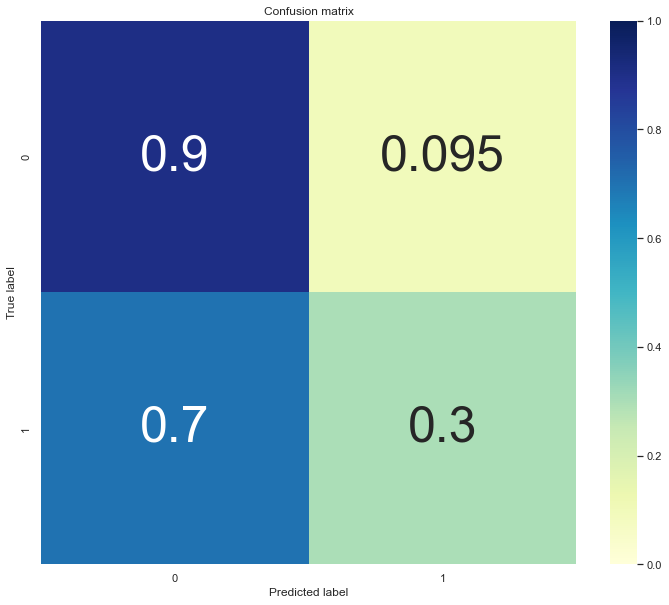

In [49]:
# Visualizing cm

cm = confusion_matrix(y_train, y_pred)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

plot_confusion_matrix(cm_norm, classes = log_reg.classes_, title='Confusion matrix')

In [50]:
log_reg.classes_

array([0, 1])

In [51]:
cm.sum(axis=1)
cm_norm

array([[0.904707, 0.095293],
       [0.702465, 0.297535]])

In [52]:
cm

array([[6228,  656],
       [4389, 1859]], dtype=int64)

In [53]:
cm.sum(axis=0)

array([10617,  2515], dtype=int64)

In [54]:
np.diag(cm)

array([6228, 1859], dtype=int64)

### Calculating False Positives (FP), False Negatives (FN), True Positives (TP) & True Negatives (TN)

In [55]:
# Calculating False Positives (FP), False Negatives (FN), True Positives (TP) & True Negatives (TN)

FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)


# Sensitivity, hit rate, recall, or true positive rate
TPR = TP / (TP + FN)
print("The True Positive Rate is:", TPR)

# Precision or positive predictive value
PPV = TP / (TP + FP)
print("The Precision is:", PPV)

# False positive rate or False alarm rate
FPR = FP / (FP + TN)
print("The False positive rate is:", FPR)


# False negative rate or Miss Rate
FNR = FN / (FN + TP)
print("The False Negative Rate is: ", FNR)



##Total averages :
print("")
print("The average TPR is:", TPR.sum()/2)
print("The average Precision is:", PPV.sum()/2)
print("The average False positive rate is:", FPR.sum()/2)
print("The average False Negative Rate is:", FNR.sum()/2)


The True Positive Rate is: [0.904707 0.297535]
The Precision is: [0.586606 0.739165]
The False positive rate is: [0.702465 0.095293]
The False Negative Rate is:  [0.095293 0.702465]

The average TPR is: 0.6011208886088173
The average Precision is: 0.6628856979625497
The average False positive rate is: 0.39887911139118265
The average False Negative Rate is: 0.39887911139118265


#### Logarithmic loss - or Log Loss - or cross-entropy loss

- Log Loss is an error metric
- This is the loss function used in (multinomial) logistic regression and extensions of it such as neural networks, defined as the negative log-likelihood of the true labels given a probabilistic classifier’s predictions. 

- Why it's important? For example, imagine having 2 models / classifiers that both predict one observation correctly (Good Loan). However, 1 classifier has a predicted probability of 0.54 and the other 0.95. Which one will you choose? Classification Accuracy will not help here as it will get both on 100%

- Doc: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html

In [56]:
# Running Log loss on training
print("The Log Loss on Training is: ", log_loss(y_train, pred_proba))

# Running Log loss on testing
pred_proba_t = log_reg.predict_proba(X_test)
print("The Log Loss on Testing Dataset is: ", log_loss(y_test, pred_proba_t))


The Log Loss on Training is:  0.573352137453961
The Log Loss on Testing Dataset is:  0.5799263795911559


## 6- Parameter Tuning:The following parameters (accuracy, sensitivity, precision / recall, F1 score) determine the accuracy score of the algorithm

## Hyper Parameter Tuning

- We will loop over parameter C (Inverse of regularization strength).
- Inverse of regularization strength helps to avoid overfitting - it penalizes large values of your parameters
- It also helps to find Global Minimum by moving to better "solutions" from local minimum to global minimum
- The values of C to search should be n-equally-spaced values in log space ranging from 1e-5 to 1e5

In [57]:
np.geomspace(1e-5, 1e5, num=20)

array([0.000010, 0.000034, 0.000113, 0.000379, 0.001274, 0.004281,
       0.014384, 0.048329, 0.162378, 0.545559, 1.832981, 6.158482,
       20.691381, 69.519280, 233.572147, 784.759970, 2636.650899,
       8858.667904, 29763.514416, 100000.000000])

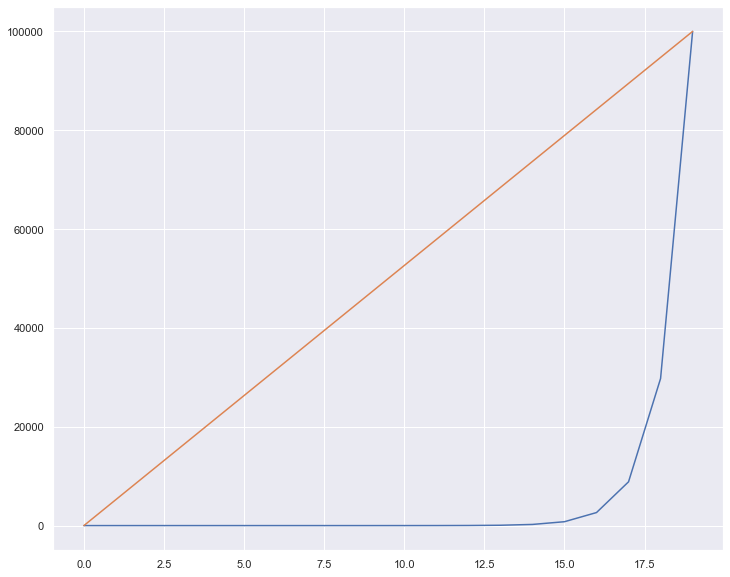

In [58]:
# Creating a range for C values
np.geomspace(1e-5, 1e5, num=20)

# ploting it
plt.plot(np.geomspace(1e-5, 1e5, num=20)) #  uniformly distributed in log space
plt.plot(np.linspace(1e-5, 1e5, num=20)) # uniformly distributed in linear space, instead of log space
# plt.plot(np.logspace(np.log10(1e-5) , np.log10(1e5) , num=20)) # same as geomspace


In [59]:
# Looping over the parameters

C_List = np.geomspace(1e-5, 1e5, num=20)
CA = []
Logarithmic_Loss = []

for c in C_List:
    log_reg2 = LogisticRegression(random_state=10, solver = 'newton-cg', C=c)
    log_reg2.fit(X_train, y_train)
    score = log_reg2.score(X_test, y_test)
    CA.append(score)
    print("The CA of C parameter {} is {}:".format(c, score))
    pred_proba_t = log_reg2.predict_proba(X_test)
    log_loss2 = log_loss(y_test, pred_proba_t)
    Logarithmic_Loss.append(log_loss2)
    print("The Logg Loss of C parameter {} is {}:".format(c, log_loss2))
    print("")

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\teutu\anaconda3\lib\site-packag

The CA of C parameter 1e-05 is 0.5921052631578947:
The Logg Loss of C parameter 1e-05 is 0.6790868852890656:



C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 3.359818286283781e-05 is 0.5932017543859649:
The Logg Loss of C parameter 3.359818286283781e-05 is 0.6748213090692311:



C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 0.00011288378916846884 is 0.5932017543859649:
The Logg Loss of C parameter 0.00011288378916846884 is 0.67363523204601:



C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 0.000379269019073225 is 0.5932017543859649:
The Logg Loss of C parameter 0.000379269019073225 is 0.6726665067112512:



C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 0.0012742749857031334 is 0.5932017543859649:
The Logg Loss of C parameter 0.0012742749857031334 is 0.6687171778847456:



C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 0.004281332398719391 is 0.5932017543859649:
The Logg Loss of C parameter 0.004281332398719391 is 0.6597247503135553:



C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 0.01438449888287663 is 0.6016995614035088:
The Logg Loss of C parameter 0.01438449888287663 is 0.636235492199956:



C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 0.04832930238571752 is 0.6175986842105263:
The Logg Loss of C parameter 0.04832930238571752 is 0.6085861828775472:



C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 0.1623776739188721 is 0.6156798245614035:
The Logg Loss of C parameter 0.1623776739188721 is 0.609749221043647:



C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iteration

The CA of C parameter 0.5455594781168515 is 0.6148574561403509:
The Logg Loss of C parameter 0.5455594781168515 is 0.5794630589128333:



C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 1.8329807108324339 is 0.6200657894736842:
The Logg Loss of C parameter 1.8329807108324339 is 0.5729954834416505:



C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 6.1584821106602545 is 0.6143092105263158:
The Logg Loss of C parameter 6.1584821106602545 is 0.5807325858141283:



C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 20.6913808111479 is 0.6145833333333334:
The Logg Loss of C parameter 20.6913808111479 is 0.58971447941002:



C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 69.51927961775606 is 0.6145833333333334:
The Logg Loss of C parameter 69.51927961775606 is 0.5905773572064642:



C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 233.57214690901213 is 0.6148574561403509:
The Logg Loss of C parameter 233.57214690901213 is 0.6002661699961869:



C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 784.7599703514607 is 0.6203399122807017:
The Logg Loss of C parameter 784.7599703514607 is 0.5777943528389153:



C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 2636.6508987303555 is 0.6132127192982456:
The Logg Loss of C parameter 2636.6508987303555 is 0.5762986926005184:



C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 8858.667904100832 is 0.6143092105263158:
The Logg Loss of C parameter 8858.667904100832 is 0.5789976720471813:



C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 29763.51441631313 is 0.6110197368421053:
The Logg Loss of C parameter 29763.51441631313 is 0.5708531017913956:



C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 100000.0 is 0.6137609649122807:
The Logg Loss of C parameter 100000.0 is 0.5749006925748152:



In [60]:
# putting the outcomes in a Table

# reshaping
CA2 = np.array(CA).reshape(20,)
Logarithmic_Loss2 = np.array(Logarithmic_Loss).reshape(20,)

# zip
outcomes = zip(C_List, CA2, Logarithmic_Loss2)

#df
df_outcomes = pd.DataFrame(outcomes, columns = ["C_List", 'CA2','Logarithmic_Loss2'])

#print
df_outcomes

# Ordering the data (sort_values)
df_outcomes.sort_values("Logarithmic_Loss2", ascending = True).reset_index()

index         C_List       CA2  Logarithmic_Loss2
0      18   29763.514416  0.611020           0.570853
1      10       1.832981  0.620066           0.572995
2      19  100000.000000  0.613761           0.574901
3      16    2636.650899  0.613213           0.576299
4      15     784.759970  0.620340           0.577794
5      17    8858.667904  0.614309           0.578998
6       9       0.545559  0.614857           0.579463
7      11       6.158482  0.614309           0.580733
8      12      20.691381  0.614583           0.589714
9      13      69.519280  0.614583           0.590577
10     14     233.572147  0.614857           0.600266
11      7       0.048329  0.617599           0.608586
12      8       0.162378  0.615680           0.609749
13      6       0.014384  0.601700           0.636235
14      5       0.004281  0.593202           0.659725
15      4       0.001274  0.593202           0.668717
16      3       0.000379  0.593202           0.672667
17      2       0.000113  0.593202           0.673635
18      1       0.000034  0.593202           0.674821
19      0       0.000010  0.592105           0.679087

In [61]:
# Another way of doing the above
# Scikit-learn offers a LogisticRegressionCV module which implements Logistic Regression 
# with builtin cross-validation to find out the optimal C parameter

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, random_state=0, shuffle=True)

# Logistic Reg CV
Log_reg3 = LogisticRegressionCV(random_state=15, Cs = C_List, solver ='newton-cg')
Log_reg3.fit(X_train, y_train)
print("The CA is:", Log_reg3.score(X_test, y_test))
pred_proba_t = Log_reg3.predict_proba(X_test)
log_loss3 = log_loss(y_test, pred_proba_t)
print("The Logistic Loss is: ", log_loss3)

print("The optimal C parameter is: ", Log_reg3.C_)



# Doc: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packag

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packag

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding er

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packag

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line se

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teu

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packag

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packag

The CA is: 0.6167763157894737
The Logistic Loss is:  0.5637238899410808
The optimal C parameter is:  [8858.667904]


C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packag

### K-fold cross validation:
Advantage: K-fold cross validation uses all the training data to train the model, by applying k different splits; repeated train-test splits converge to the true accuracy given that the training data is representable for the underlying distribution; however in practise this is often overoptimistic.
Disadvantage: The disadvantage of this method is that the training algorithm has to be rerun from the beginning k times, which means it takes k times as much computation to get an evaluation. Additionally, if you want to test the performance on a completely new dataset that the algorithm has never seen, you cannot do this with k-fold cross validation.

### Hold-out:
Advantage: The advantage of Hold-out is that you can test how your model performs on completely unseen data that you haven't used when training the model. Additionally, Hold-out is usually much faster and less computationally expensive. 
Disadvantage: The evaluation may depend heavily on which data points end up in the training set and which end up in the test set, and thus the evaluation may be significantly different depending on how the division is made.

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 1e-05 is 0.5921052631578947:
The Logg Loss of C parameter 1e-05 is 0.6790868852890656:



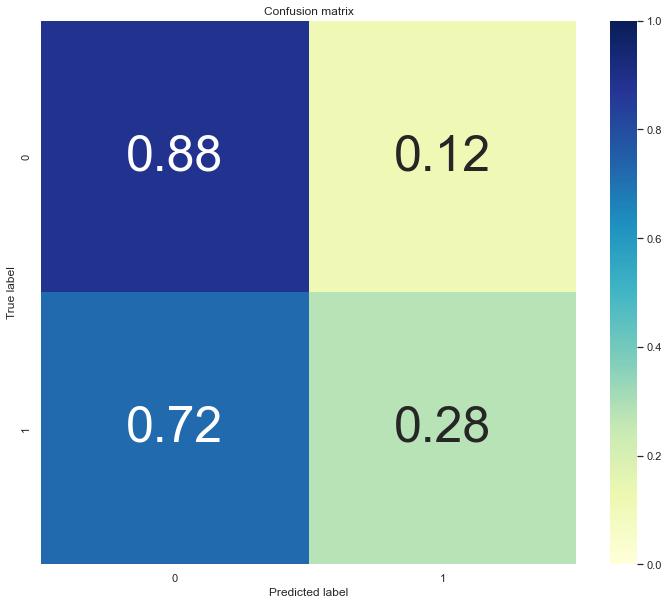

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 3.359818286283781e-05 is 0.5932017543859649:
The Logg Loss of C parameter 3.359818286283781e-05 is 0.6748213090692311:



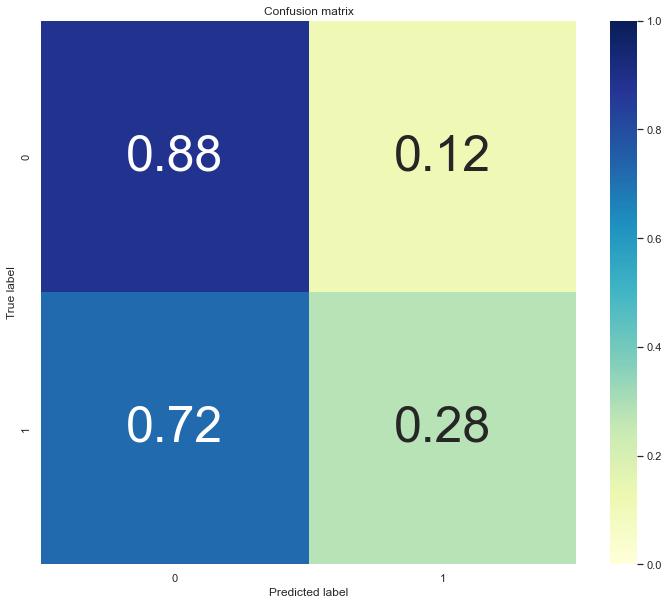

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 0.00011288378916846884 is 0.5932017543859649:
The Logg Loss of C parameter 0.00011288378916846884 is 0.67363523204601:



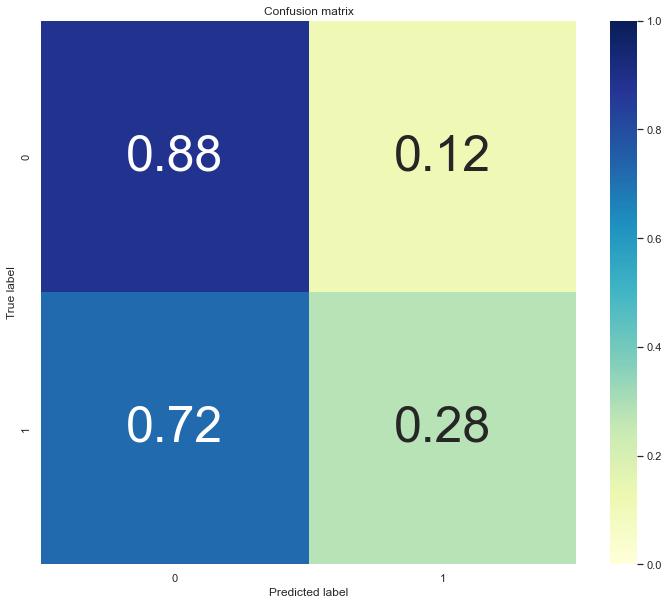

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  wa

The CA of C parameter 0.000379269019073225 is 0.5932017543859649:
The Logg Loss of C parameter 0.000379269019073225 is 0.6726665067112512:



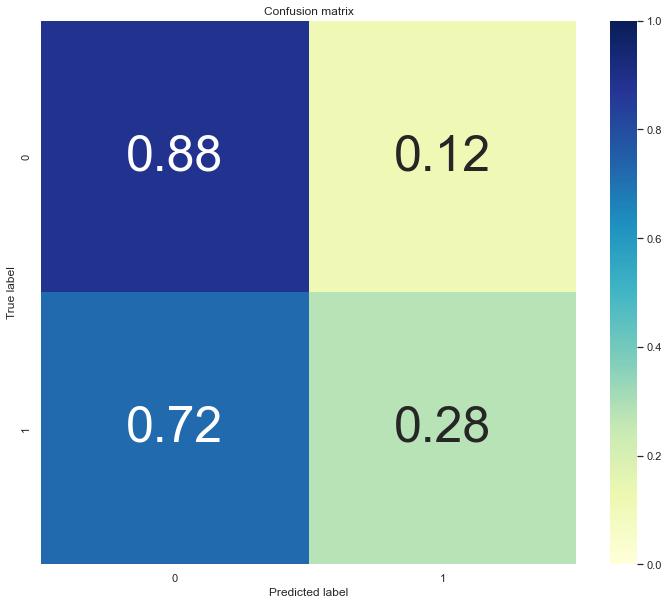

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 0.0012742749857031334 is 0.5932017543859649:
The Logg Loss of C parameter 0.0012742749857031334 is 0.6687171778847456:



C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


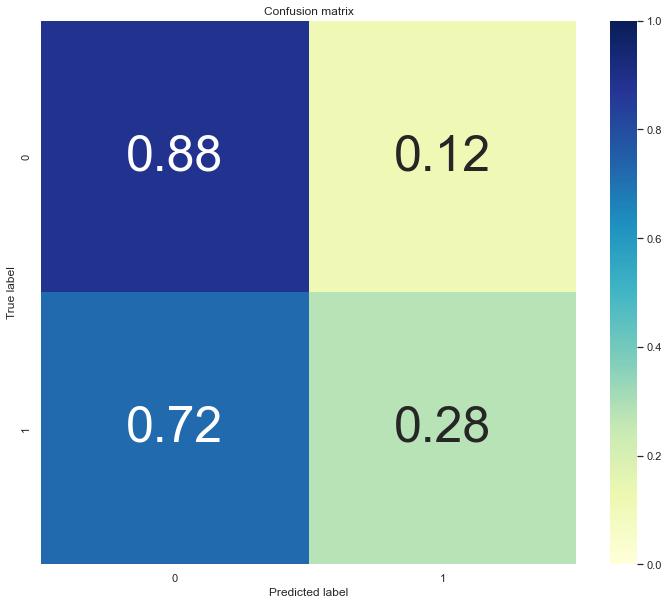

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 0.004281332398719391 is 0.5932017543859649:
The Logg Loss of C parameter 0.004281332398719391 is 0.6597247503135553:



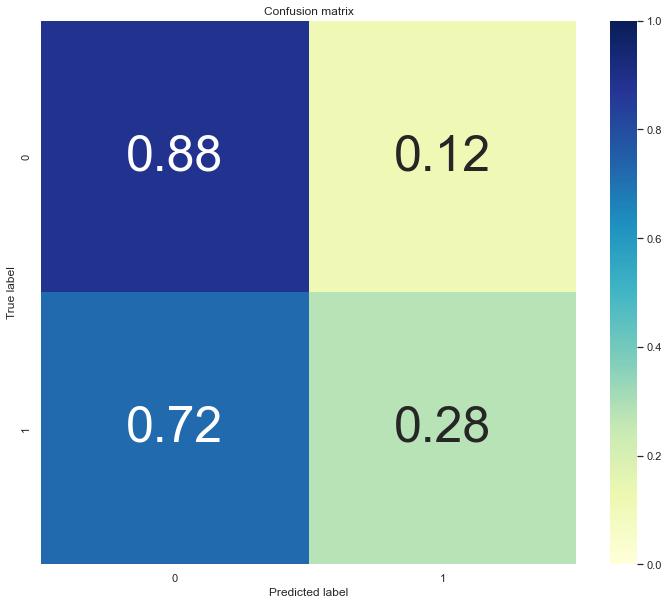

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 0.01438449888287663 is 0.6016995614035088:
The Logg Loss of C parameter 0.01438449888287663 is 0.636235492199956:



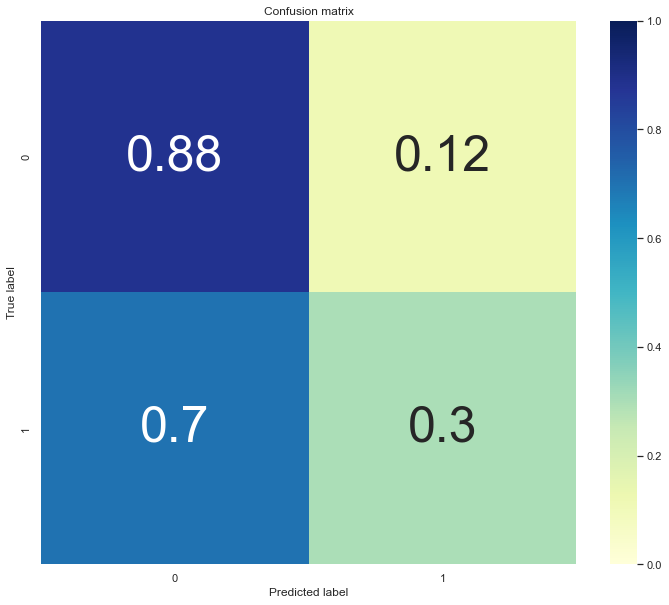

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 0.04832930238571752 is 0.6175986842105263:
The Logg Loss of C parameter 0.04832930238571752 is 0.6085861828775472:



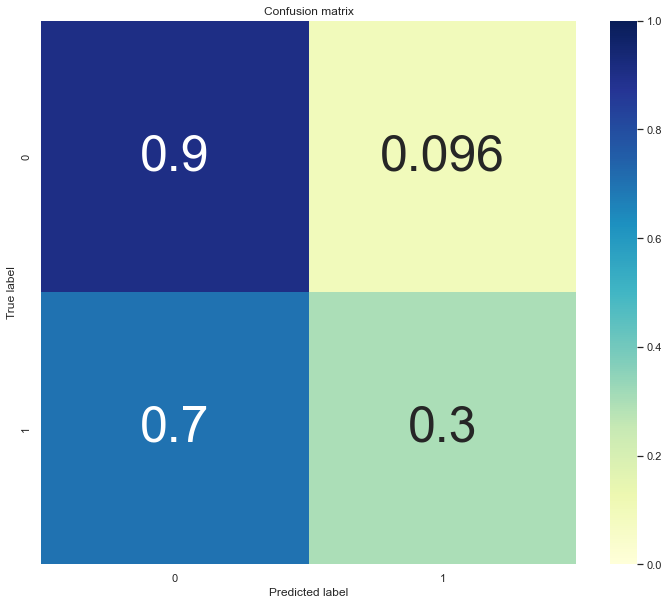

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 0.1623776739188721 is 0.6156798245614035:
The Logg Loss of C parameter 0.1623776739188721 is 0.609749221043647:



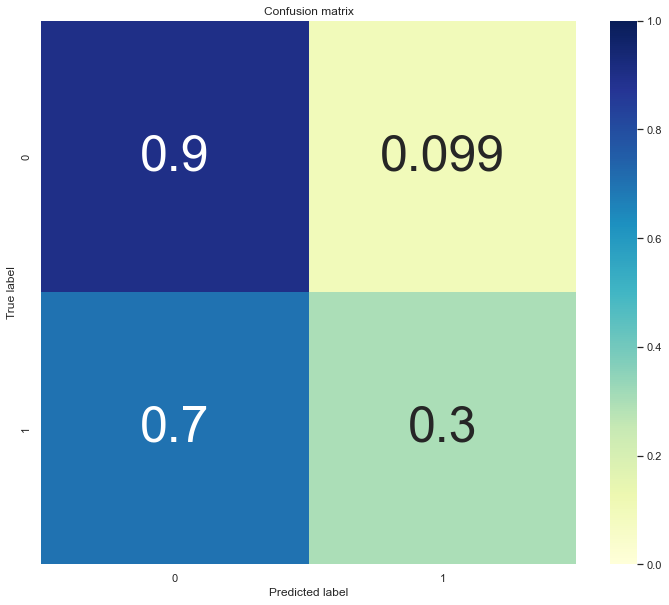

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 0.5455594781168515 is 0.6148574561403509:
The Logg Loss of C parameter 0.5455594781168515 is 0.5794630589128333:



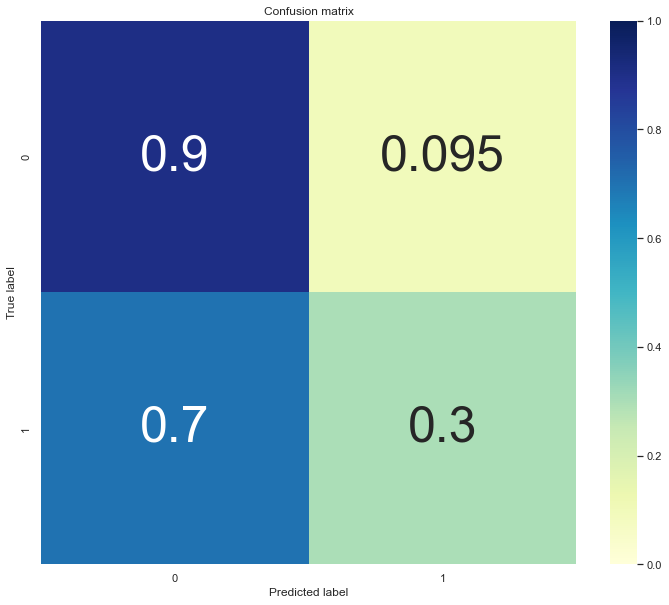

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 1.8329807108324339 is 0.6200657894736842:
The Logg Loss of C parameter 1.8329807108324339 is 0.5729954834416505:



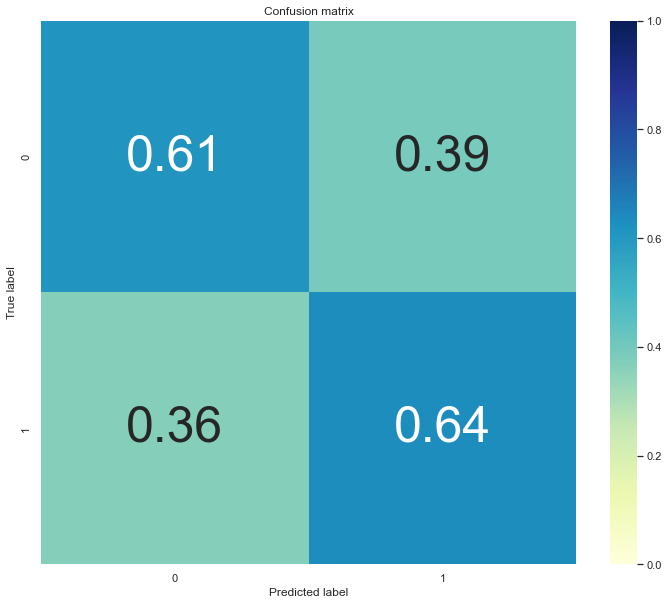

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 6.1584821106602545 is 0.6143092105263158:
The Logg Loss of C parameter 6.1584821106602545 is 0.5807325858141283:



C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


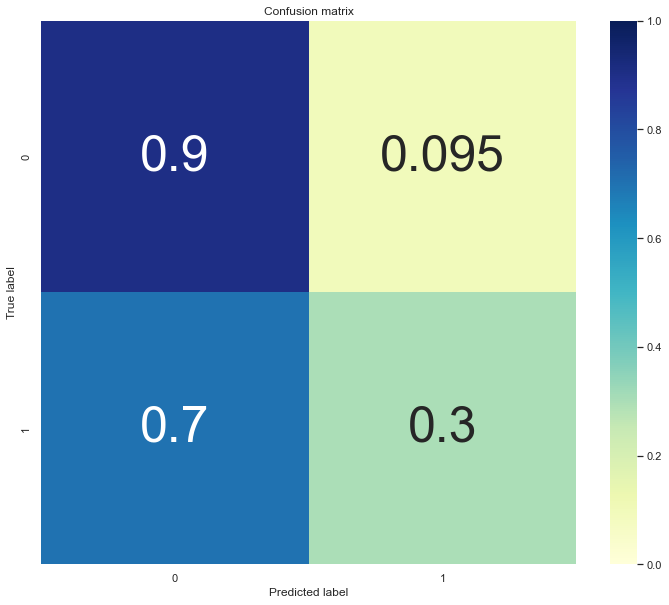

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 20.6913808111479 is 0.6145833333333334:
The Logg Loss of C parameter 20.6913808111479 is 0.58971447941002:



C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


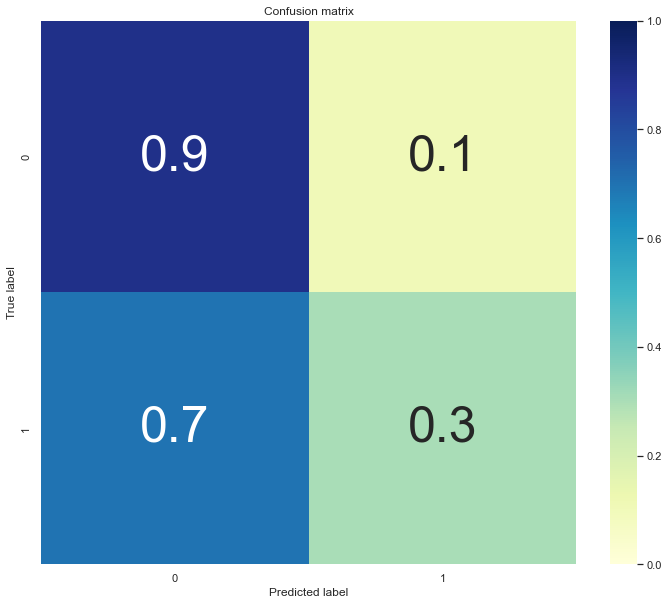

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 69.51927961775606 is 0.6145833333333334:
The Logg Loss of C parameter 69.51927961775606 is 0.5905773572064642:



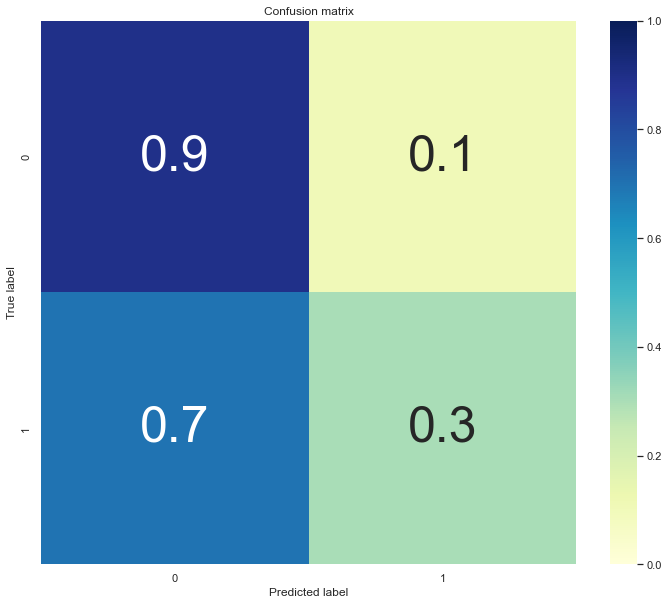

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 233.57214690901213 is 0.6148574561403509:
The Logg Loss of C parameter 233.57214690901213 is 0.6002661699961869:



C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


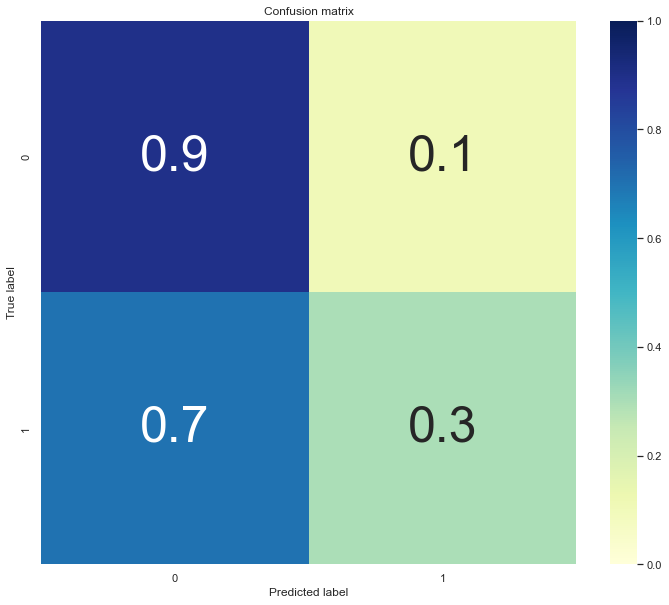

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 784.7599703514607 is 0.6203399122807017:
The Logg Loss of C parameter 784.7599703514607 is 0.5777943528389153:



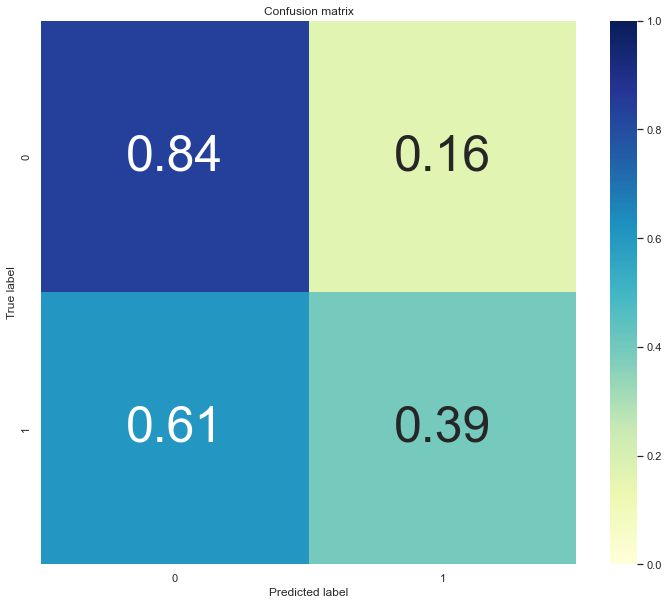

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 2636.6508987303555 is 0.6132127192982456:
The Logg Loss of C parameter 2636.6508987303555 is 0.5762986926005184:



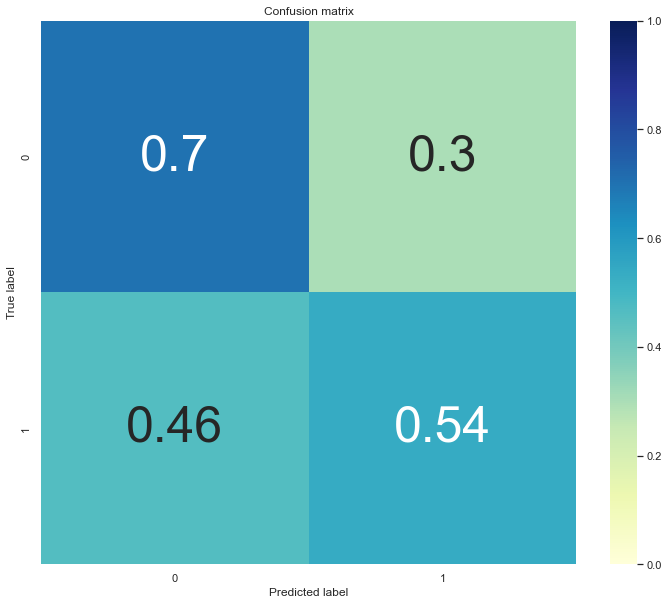

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 8858.667904100832 is 0.6143092105263158:
The Logg Loss of C parameter 8858.667904100832 is 0.5789976720471813:



C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


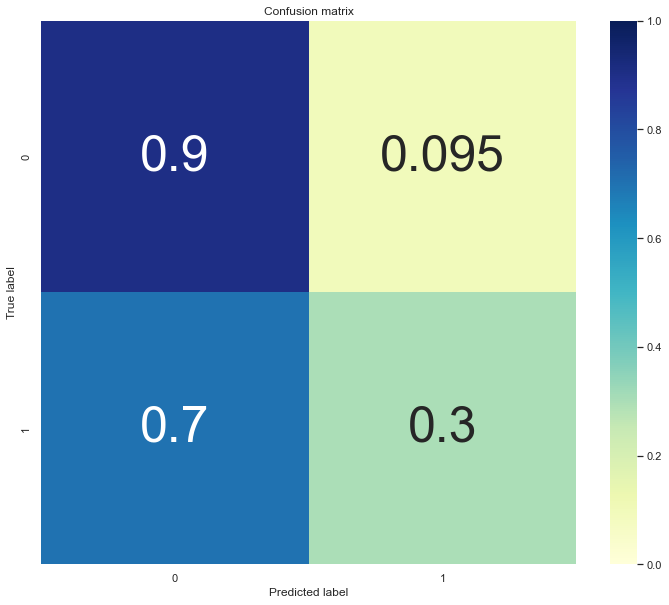

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,


The CA of C parameter 29763.51441631313 is 0.6110197368421053:
The Logg Loss of C parameter 29763.51441631313 is 0.5708531017913956:



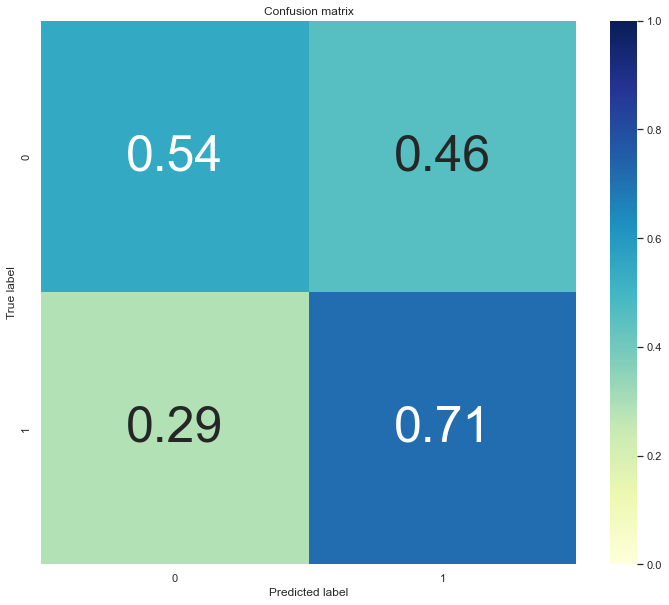

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

The CA of C parameter 100000.0 is 0.6137609649122807:
The Logg Loss of C parameter 100000.0 is 0.5749006925748152:



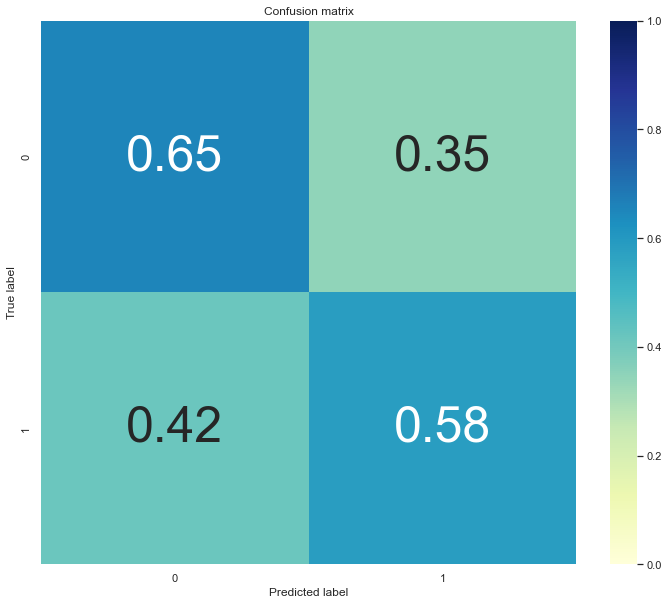

In [62]:
# Maybe we have a different metric we want to track

# Looping over the parameters

C_List = np.geomspace(1e-5, 1e5, num=20)
CA = []
Logarithmic_Loss = []

for c in C_List:
    log_reg2 = LogisticRegression(random_state=10, solver = 'newton-cg', C=c)
    log_reg2.fit(X_train, y_train)
    score = log_reg2.score(X_test, y_test)
    CA.append(score)
    print("The CA of C parameter {} is {}:".format(c, score))
    pred_proba_t = log_reg2.predict_proba(X_test)
    log_loss2 = log_loss(y_test, pred_proba_t)
    Logarithmic_Loss.append(log_loss2)
    print("The Logg Loss of C parameter {} is {}:".format(c, log_loss2))
    print("")
    
    y_pred = log_reg2.predict(X_train)
    cm = confusion_matrix(y_train, y_pred)
    cm_norm = cm / cm.sum(axis=1).reshape(-1,1)
    plot_confusion_matrix(cm_norm, classes = log_reg.classes_, title='Confusion matrix')
    plt.show()
  

In [63]:
# Training a Dummy Classifier

from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
score = dummy_clf.score(X_test, y_test)

pred_proba_t = dummy_clf.predict_proba(X_test)
log_loss2 = log_loss(y_test, pred_proba_t)

print("Testing Acc:", score)
print("Log Loss:", log_loss2)


# Doc: https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

Testing Acc: 0.5290570175438597
Log Loss: 16.265794365804975


## 11. Final Model with Selected Parameters

In [65]:
# Final Model 

log_reg3 = LogisticRegression(random_state=10, solver = 'newton-cg', C=784.759970)
log_reg3.fit(X_train, y_train)
score = log_reg3.score(X_valid, y_valid)

pred_proba_t = log_reg3.predict_proba(X_valid)
log_loss2 = log_loss(y_valid, pred_proba_t)

print("Testing Acc:", score)
print("Log Loss:", log_loss2)

C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

Testing Acc: 0.6294520547945206
Log Loss: 0.5668741315335623


C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\teutu\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


## 12. How to use our L. Regression model

#### 

- Option 1: Deploy the model in a CRM System or the Cloud or Viz tools and automaticaly decide if a customer should get his loan approved or not


- Option 2: Analyse the factors that affect a good/bad loan and help the business understand this. Then the business can educate their clients what they need to improve in order to get a loan


- Option 3: Deploy this model in an open bank website where customers can automatically see if their loan will get approved or not; saving time & cost for the bank/business


- Option 4 - What do you think?